In [1]:
from tools_stance import * 
from models import *
from transformer_class import *
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences
import os 
import torch 
import gc
import pandas as pd

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

keys=["commenting", "support", "denying", "questioning"]

path="../../../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl


embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


(1193513, 200)

In [51]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size, mode, x_train, lab_str_embeddings, index_embeddings): 
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=x_train.shape[0]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=x_val.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0] for x in x_list]   
        objs=val['Tw_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels)  
    if mode=='Test':
        max_objs=x_test.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0]+x_val.shape[0] for x in x_list]
        total=x_train.shape[0]+x_val.shape[0]
        objs=test['Tw_id']  
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------  
    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]]  
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [52]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [53]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [54]:
path_m='../../../Datasets/Models_Stance/'

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [55]:
    
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()    
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
        # loss.data[0] * norm

In [56]:
from bert_serving.client import BertClient
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

#sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
#                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
#    plt.show()
    
bc = BertClient()  

In [57]:
n_machines=5

In [58]:
path_a='../../../Datasets/CSV_Stance/Aumento_ofi/' 

In [61]:
def train_transformer(prob, num_epochs, path_a, path_m, c_gama, class_weights=np.ones(4), xfrom=1, xto=20, x_train=x_train, sentences=sentences, labels_train=labels_train, augmented=False):    
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    global_attn=[]
    best_macro={'F_ma':0.1 , 'Run':0}

    bs=32
    if augmented:
        tope=11218
    else:
        tope=4520
    for x in range(xfrom, xto + 1):
        if augmented:
            macro_augmented= np.load(path_a + 'balance_GloVe_' + str(int(prob*100)) + '_'+ str(x)+'_run.npy', allow_pickle=True)
            ids_train=macro_augmented[:,0]
            tws_train=macro_augmented[:,1]
            labels_train=macro_augmented[:,2]
            class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
            print ("Pesos de clases:", class_weights)

            etiq=np.asarray(labels_train)
            sentences = tws_train
            n_labels = etiq.copy()
            y_train=to_categorical(n_labels,num_classes=4)

            input_ids=[]
            for sent in sentences:
                encoded_sent=[]
                for wd in sent:
                    try:
                        encoded_sent.append(token_2_idx[wd])
                    except:
                        continue
                input_ids.append(encoded_sent)

            input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
            shape=np.asarray(input_ids).shape

            x_train=np.zeros((shape[0], shape[1], emb))
            j=0
            for in_id in input_ids:
                x_train[j]=EMB_matrix[in_id]
                j+=1

        ################################################    
        print ("Entrenando Run #", x)
        
        b_dim=768
        espacio=[np.ones(b_dim)]
        Ks= ortho_group.rvs(dim=b_dim)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']
        
        if augmented:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                tw=' '.join([word for word in tw_tr])
                vector= bc.encode([tw])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert) 
        
        else:
            for i in range(len(sentences)):
                tw_tr=sentences[i]
                clase=dict_cl[labels_train[i]]            
                encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
                vector=bc.encode([encoded_tok])[0]
                final_bert= vector

                index_embeddings.append(i+5)
                lab_str_embeddings.append(clase)
                K_list_ext.append(final_bert)

        objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
        objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])   
        
        for num in range(len(llaves)):
            i=llaves[num]
            clase=clases[num]
            tw_tr=sent_all[num]
            encoded_tok = cleaner(tw_tr)[0]  #cleaner: raw, no cleaner:augmented version
            vector=bc.encode([encoded_tok])[0]
            final_bert= vector

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)


        K_list_new= np.asarray(K_list_ext, dtype='float32')

        ###################################### TRANSFORMER ###############################
        hist_train_loss=[]
        hist_train_acc=[]
        hist_train_fma=[]
        hist_val_loss=[]
        hist_val_acc=[]
        hist_val_fma=[]

        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', x_train, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', x_train, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', x_train, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-3])
        glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-3])

        plot_cm(cm_norma(glo_cm),["S", "D", "Q", "C"],"BERT Transformer ", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            print ("\n\nNuevo best encontrado:\n")
            print ("Acc: %.3f" % glo_acc, "\tF1-ma: %.3f" % glo_fma)
            np.set_printoptions(precision=3)
            print ("\tF1-none: ", glo_fno)
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.288 	F-macro_val: 0.208
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.197
Epoch 30 	acc_val: 0.622 	F-macro_val: 0.207
Epoch 40 	acc_val: 0.632 	F-macro_val: 0.222
Epoch 50 	acc_val: 0.642 	F-macro_val: 0.237
Epoch 60 	acc_val: 0.646 	F-macro_val: 0.238
Epoch 70 	acc_val: 0.642 	F-macro_val: 0.240
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


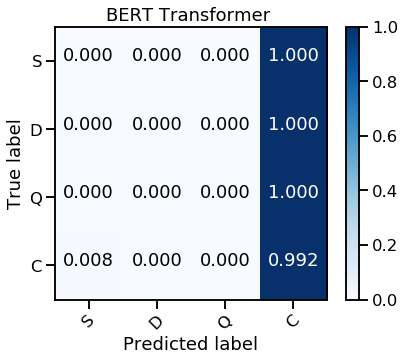

Test_ acc: 0.7561214495592556
Test_ f1 none: [0.    0.    0.    0.861]
Test_ f1 macro: 0.21528165086447293


Nuevo best encontrado:

Acc: 0.756 	F1-ma: 0.215
	F1-none:  [0.    0.    0.    0.861]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.146 	F-macro_val: 0.138
Epoch 10 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 40 	acc_val: 0.618 	F-macro_val: 0.195
Epoch 50 	acc_val: 0.632 	F-macro_val: 0.229
Epoch 60 	acc_val: 0.649 	F-macro_val: 0.243
Epoch 70 	acc_val: 0.653 	F-macro_val: 0.245
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


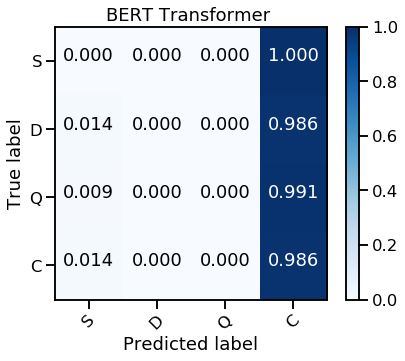

Test_ acc: 0.7512242899118511
Test_ f1 none: [0.    0.    0.    0.859]
Test_ f1 macro: 0.2147256438969765
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.608 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.197
Epoch 40 	acc_val: 0.618 	F-macro_val: 0.205
Epoch 50 	acc_val: 0.628 	F-macro_val: 0.211
Epoch 60 	acc_val: 0.628 	F-macro_val: 0.217
Epoch 70 	acc_val: 0.646 	F-macro_val: 0.247
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


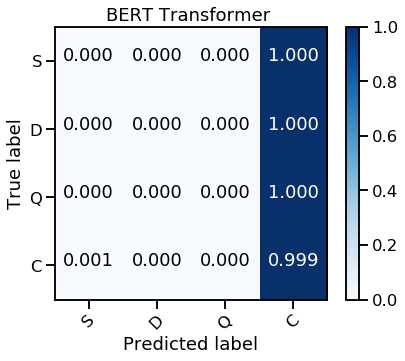

Test_ acc: 0.7610186092066601
Test_ f1 none: [0.    0.    0.    0.864]
Test_ f1 macro: 0.2160734149054505


Nuevo best encontrado:

Acc: 0.761 	F1-ma: 0.216
	F1-none:  [0.    0.    0.    0.864]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.205
Epoch 10 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.201
Epoch 40 	acc_val: 0.625 	F-macro_val: 0.204
Epoch 50 	acc_val: 0.635 	F-macro_val: 0.227
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.225
Epoch 70 	acc_val: 0.653 	F-macro_val: 0.250
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


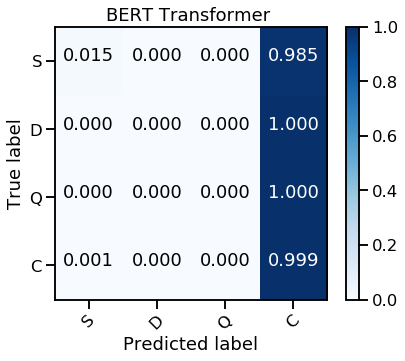

Test_ acc: 0.761998041136141
Test_ f1 none: [0.029 0.    0.    0.865]
Test_ f1 macro: 0.22333651323634632


Nuevo best encontrado:

Acc: 0.762 	F1-ma: 0.223
	F1-none:  [0.029 0.    0.    0.865]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.208 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.211
Epoch 40 	acc_val: 0.639 	F-macro_val: 0.227
Epoch 50 	acc_val: 0.646 	F-macro_val: 0.261
Epoch 60 	acc_val: 0.653 	F-macro_val: 0.255
Epoch 70 	acc_val: 0.639 	F-macro_val: 0.231
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


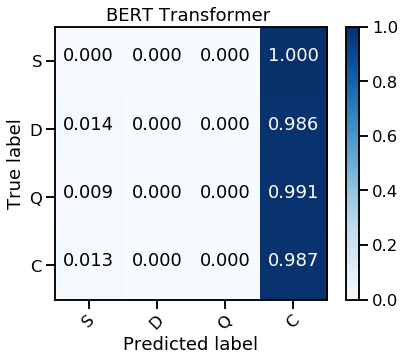

Test_ acc: 0.752203721841332
Test_ f1 none: [0.   0.   0.   0.86]
Test_ f1 macro: 0.2148852825965305
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.274 	F-macro_val: 0.221
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 30 	acc_val: 0.628 	F-macro_val: 0.214
Epoch 40 	acc_val: 0.625 	F-macro_val: 0.220
Epoch 50 	acc_val: 0.632 	F-macro_val: 0.227
Epoch 60 	acc_val: 0.649 	F-macro_val: 0.256
Epoch 70 	acc_val: 0.660 	F-macro_val: 0.281
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


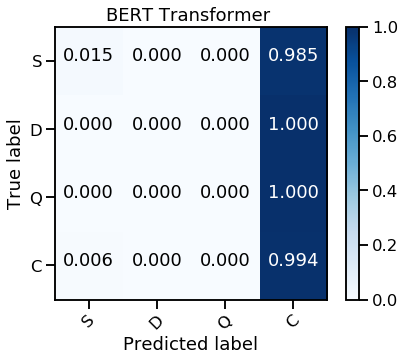

Test_ acc: 0.7580803134182175
Test_ f1 none: [0.027 0.    0.    0.862]
Test_ f1 macro: 0.22231726986328215
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.191 	F-macro_val: 0.154
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.190
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.628 	F-macro_val: 0.214
Epoch 40 	acc_val: 0.628 	F-macro_val: 0.220
Epoch 50 	acc_val: 0.632 	F-macro_val: 0.230
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.245
Epoch 70 	acc_val: 0.649 	F-macro_val: 0.264
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


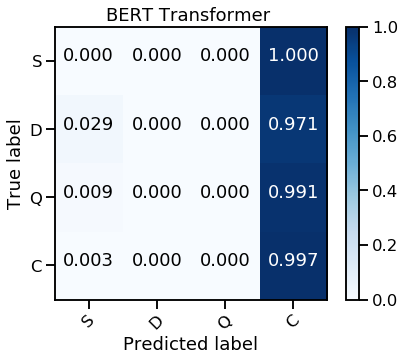

Test_ acc: 0.7600391772771793
Test_ f1 none: [0.    0.    0.    0.865]
Test_ f1 macro: 0.21627647714604234
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.196
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.197
Epoch 40 	acc_val: 0.618 	F-macro_val: 0.202
Epoch 50 	acc_val: 0.646 	F-macro_val: 0.237
Epoch 60 	acc_val: 0.653 	F-macro_val: 0.249
Epoch 70 	acc_val: 0.649 	F-macro_val: 0.245
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


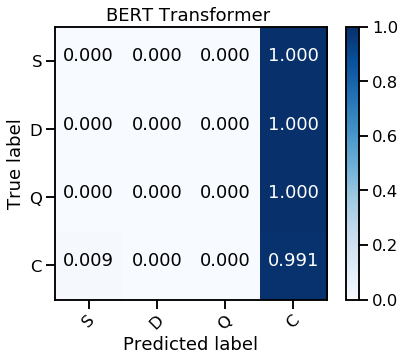

Test_ acc: 0.7551420176297747
Test_ f1 none: [0.   0.   0.   0.86]
Test_ f1 macro: 0.21512276785714282
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.191
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.622 	F-macro_val: 0.201
Epoch 40 	acc_val: 0.635 	F-macro_val: 0.217
Epoch 50 	acc_val: 0.639 	F-macro_val: 0.248
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.245
Epoch 70 	acc_val: 0.667 	F-macro_val: 0.282
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


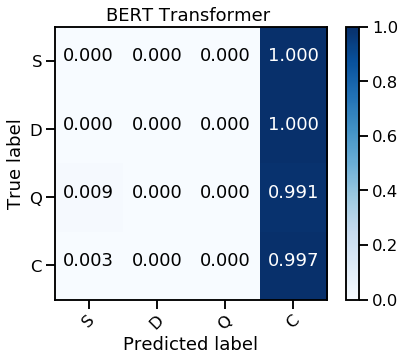

Test_ acc: 0.7600391772771793
Test_ f1 none: [0.    0.    0.    0.864]
Test_ f1 macro: 0.21603563474387527
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.285 	F-macro_val: 0.195
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.625 	F-macro_val: 0.199
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.197
Epoch 40 	acc_val: 0.622 	F-macro_val: 0.198
Epoch 50 	acc_val: 0.639 	F-macro_val: 0.222
Epoch 60 	acc_val: 0.646 	F-macro_val: 0.233
Epoch 70 	acc_val: 0.635 	F-macro_val: 0.236
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


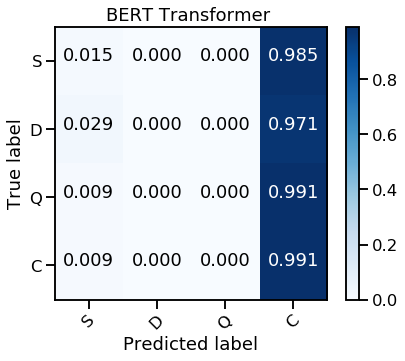

Test_ acc: 0.7561214495592556
Test_ f1 none: [0.025 0.    0.    0.862]
Test_ f1 macro: 0.22193314076968823
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.319 	F-macro_val: 0.221
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.190
Epoch 20 	acc_val: 0.608 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.202
Epoch 40 	acc_val: 0.632 	F-macro_val: 0.209
Epoch 50 	acc_val: 0.632 	F-macro_val: 0.221
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.227
Epoch 70 	acc_val: 0.635 	F-macro_val: 0.233
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


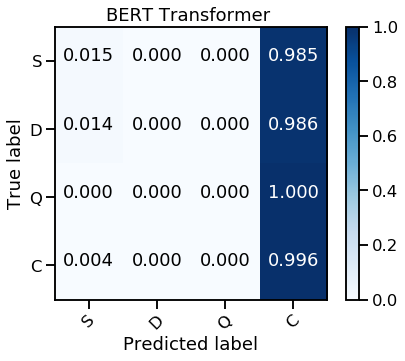

Test_ acc: 0.7600391772771793
Test_ f1 none: [0.027 0.    0.    0.864]
Test_ f1 macro: 0.22284708541408957
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.170 	F-macro_val: 0.139
Epoch 10 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 20 	acc_val: 0.615 	F-macro_val: 0.190
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.199
Epoch 40 	acc_val: 0.622 	F-macro_val: 0.202
Epoch 50 	acc_val: 0.639 	F-macro_val: 0.220
Epoch 60 	acc_val: 0.635 	F-macro_val: 0.224
Epoch 70 	acc_val: 0.642 	F-macro_val: 0.244
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


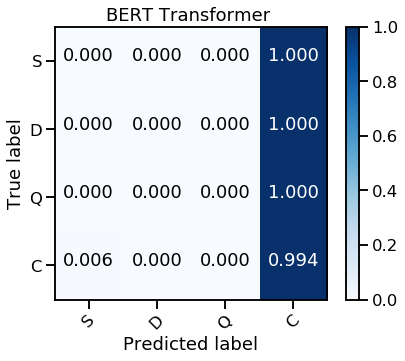

Test_ acc: 0.7571008814887366
Test_ f1 none: [0.    0.    0.    0.862]
Test_ f1 macro: 0.21544035674470458
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.260 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.196
Epoch 40 	acc_val: 0.625 	F-macro_val: 0.210
Epoch 50 	acc_val: 0.628 	F-macro_val: 0.220
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.233
Epoch 70 	acc_val: 0.653 	F-macro_val: 0.253
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


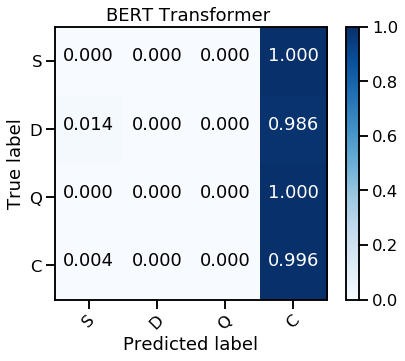

Test_ acc: 0.7590597453476984
Test_ f1 none: [0.    0.    0.    0.864]
Test_ f1 macro: 0.21587743732590528
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.210
Epoch 10 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.608 	F-macro_val: 0.189
Epoch 40 	acc_val: 0.618 	F-macro_val: 0.202
Epoch 50 	acc_val: 0.646 	F-macro_val: 0.232
Epoch 60 	acc_val: 0.639 	F-macro_val: 0.235
Epoch 70 	acc_val: 0.649 	F-macro_val: 0.256
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


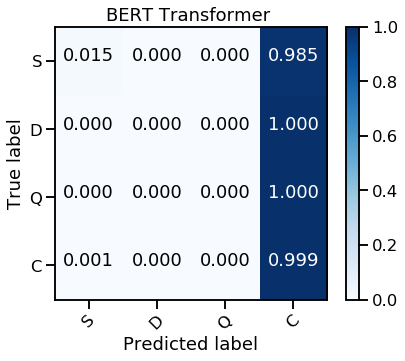

Test_ acc: 0.761998041136141
Test_ f1 none: [0.029 0.    0.    0.865]
Test_ f1 macro: 0.22333651323634632
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.354 	F-macro_val: 0.273
Epoch 10 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 40 	acc_val: 0.628 	F-macro_val: 0.215
Epoch 50 	acc_val: 0.625 	F-macro_val: 0.214
Epoch 60 	acc_val: 0.635 	F-macro_val: 0.236
Epoch 70 	acc_val: 0.646 	F-macro_val: 0.240
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


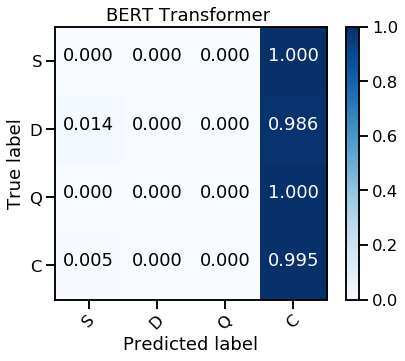

Test_ acc: 0.7580803134182175
Test_ f1 none: [0.    0.    0.    0.863]
Test_ f1 macro: 0.2157190635451505
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.217
Epoch 10 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 40 	acc_val: 0.632 	F-macro_val: 0.203
Epoch 50 	acc_val: 0.625 	F-macro_val: 0.209
Epoch 60 	acc_val: 0.628 	F-macro_val: 0.223
Epoch 70 	acc_val: 0.642 	F-macro_val: 0.232
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


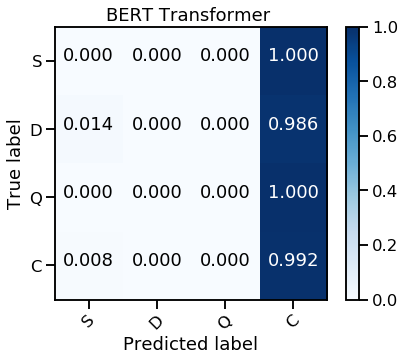

Test_ acc: 0.7561214495592556
Test_ f1 none: [0.    0.    0.    0.862]
Test_ f1 macro: 0.2154017857142857
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.323 	F-macro_val: 0.213
Epoch 10 	acc_val: 0.608 	F-macro_val: 0.189
Epoch 20 	acc_val: 0.611 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.615 	F-macro_val: 0.195
Epoch 40 	acc_val: 0.628 	F-macro_val: 0.203
Epoch 50 	acc_val: 0.628 	F-macro_val: 0.217
Epoch 60 	acc_val: 0.632 	F-macro_val: 0.214
Epoch 70 	acc_val: 0.635 	F-macro_val: 0.239
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


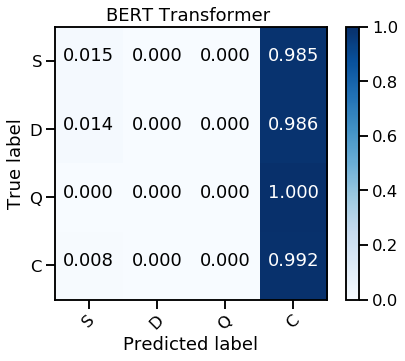

Test_ acc: 0.7571008814887366
Test_ f1 none: [0.026 0.    0.    0.862]
Test_ f1 macro: 0.22210100208645564
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.608 	F-macro_val: 0.189
Epoch 30 	acc_val: 0.625 	F-macro_val: 0.197
Epoch 40 	acc_val: 0.618 	F-macro_val: 0.201
Epoch 50 	acc_val: 0.625 	F-macro_val: 0.216
Epoch 60 	acc_val: 0.628 	F-macro_val: 0.222
Epoch 70 	acc_val: 0.639 	F-macro_val: 0.232
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


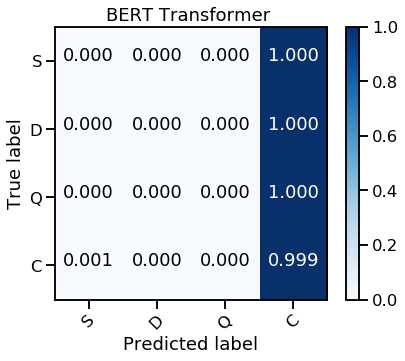

Test_ acc: 0.7610186092066601
Test_ f1 none: [0.    0.    0.    0.864]
Test_ f1 macro: 0.2160734149054505
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.274 	F-macro_val: 0.216
Epoch 10 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.622 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.618 	F-macro_val: 0.203
Epoch 40 	acc_val: 0.622 	F-macro_val: 0.208
Epoch 50 	acc_val: 0.628 	F-macro_val: 0.224
Epoch 60 	acc_val: 0.628 	F-macro_val: 0.223
Epoch 70 	acc_val: 0.649 	F-macro_val: 0.246
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


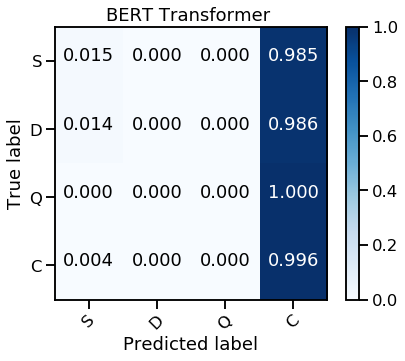

Test_ acc: 0.7600391772771793
Test_ f1 none: [0.027 0.    0.    0.864]
Test_ f1 macro: 0.22284708541408957
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.229 	F-macro_val: 0.166
Epoch 10 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 20 	acc_val: 0.618 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.622 	F-macro_val: 0.202
Epoch 40 	acc_val: 0.646 	F-macro_val: 0.233
Epoch 50 	acc_val: 0.667 	F-macro_val: 0.258
Epoch 60 	acc_val: 0.649 	F-macro_val: 0.249
Epoch 70 	acc_val: 0.656 	F-macro_val: 0.261
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


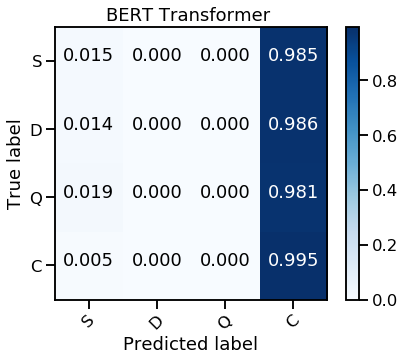

Test_ acc: 0.7590597453476984
Test_ f1 none: [0.026 0.    0.    0.864]
Test_ f1 macro: 0.2226593493784713


In [62]:
path_a = '../../../Datasets/CSV_Stance/Aumento_ofi/' 
best_0, all_accs_0, all_fno_0, all_ma_0, all_cm_0 = train_transformer(0.0, 75, path_a, path_m, "Blues")

In [63]:
print ("best_0", best_0)
print ("all_accs_0", all_accs_0)
print ("all_fno_0", all_fno_0)
print ("all_ma_0", all_ma_0)

best_0 {'F_ma': 0.22333651323634632, 'Run': 4}
all_accs_0 [0.7561214495592556, 0.7512242899118511, 0.7610186092066601, 0.761998041136141, 0.752203721841332, 0.7580803134182175, 0.7600391772771793, 0.7551420176297747, 0.7600391772771793, 0.7561214495592556, 0.7600391772771793, 0.7571008814887366, 0.7590597453476984, 0.761998041136141, 0.7580803134182175, 0.7561214495592556, 0.7571008814887366, 0.7610186092066601, 0.7600391772771793, 0.7590597453476984]
all_fno_0 [array([0.   , 0.   , 0.   , 0.861]), array([0.   , 0.   , 0.   , 0.859]), array([0.   , 0.   , 0.   , 0.864]), array([0.029, 0.   , 0.   , 0.865]), array([0.  , 0.  , 0.  , 0.86]), array([0.027, 0.   , 0.   , 0.862]), array([0.   , 0.   , 0.   , 0.865]), array([0.  , 0.  , 0.  , 0.86]), array([0.   , 0.   , 0.   , 0.864]), array([0.025, 0.   , 0.   , 0.862]), array([0.027, 0.   , 0.   , 0.864]), array([0.   , 0.   , 0.   , 0.862]), array([0.   , 0.   , 0.   , 0.864]), array([0.029, 0.   , 0.   , 0.865]), array([0.   , 0.   , 0.

Acc: 0.758 -- deviation: 0.003
F-score: 0.218 -- deviation: 0.004
(0.0) SDQC: 0.010845621968070016 0.0 0.0 0.8628125559608811


Confusion counts
[[8.000e+00 0.000e+00 0.000e+00 1.352e+03]
 [1.300e+01 0.000e+00 0.000e+00 1.367e+03]
 [7.000e+00 0.000e+00 0.000e+00 2.113e+03]
 [8.800e+01 0.000e+00 0.000e+00 1.547e+04]]


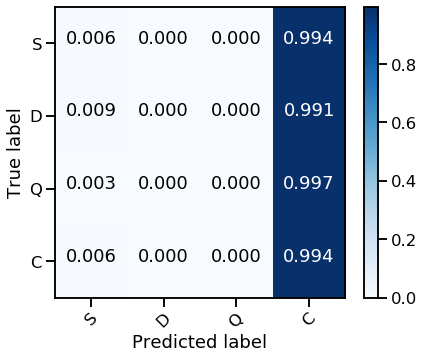

In [64]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0)[:,0])
den=np.mean(np.asarray(all_fno_0)[:,1])
que=np.mean(np.asarray(all_fno_0)[:,2])
com=np.mean(np.asarray(all_fno_0)[:,3])

print ("(0.0) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S", "D", "Q", "C"], "", cmap='Blues')

## 0.0 CW

In [65]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights

array([1.26 , 3.182, 3.211, 0.388])

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.167 	F-macro_val: 0.136
Epoch 20 	acc_val: 0.222 	F-macro_val: 0.200
Epoch 30 	acc_val: 0.247 	F-macro_val: 0.226
Epoch 40 	acc_val: 0.295 	F-macro_val: 0.273
Epoch 50 	acc_val: 0.306 	F-macro_val: 0.283
Epoch 60 	acc_val: 0.309 	F-macro_val: 0.280
Epoch 70 	acc_val: 0.323 	F-macro_val: 0.290
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


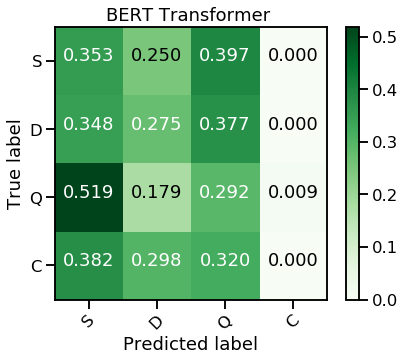

Test_ acc: 0.07247796278158668
Test_ f1 none: [0.103 0.107 0.141 0.   ]
Test_ f1 macro: 0.08763393598373506
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.186
Epoch 10 	acc_val: 0.181 	F-macro_val: 0.161
Epoch 20 	acc_val: 0.215 	F-macro_val: 0.198
Epoch 30 	acc_val: 0.253 	F-macro_val: 0.241
Epoch 40 	acc_val: 0.274 	F-macro_val: 0.262
Epoch 50 	acc_val: 0.260 	F-macro_val: 0.246
Epoch 60 	acc_val: 0.281 	F-macro_val: 0.272
Epoch 70 	acc_val: 0.299 	F-macro_val: 0.289
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


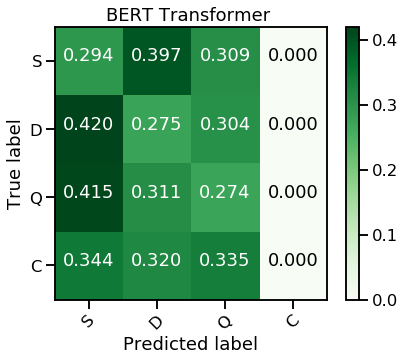

Test_ acc: 0.06660137120470128
Test_ f1 none: [0.093 0.096 0.132 0.   ]
Test_ f1 macro: 0.08034451717381913
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.212 	F-macro_val: 0.172
Epoch 10 	acc_val: 0.177 	F-macro_val: 0.146
Epoch 20 	acc_val: 0.226 	F-macro_val: 0.207
Epoch 30 	acc_val: 0.257 	F-macro_val: 0.239
Epoch 40 	acc_val: 0.292 	F-macro_val: 0.269
Epoch 50 	acc_val: 0.299 	F-macro_val: 0.285
Epoch 60 	acc_val: 0.340 	F-macro_val: 0.313
Epoch 70 	acc_val: 0.330 	F-macro_val: 0.308
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


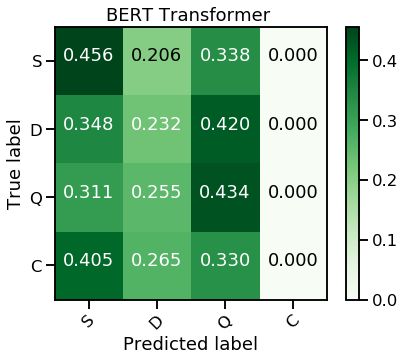

Test_ acc: 0.0910871694417238
Test_ f1 none: [0.132 0.096 0.2   0.   ]
Test_ f1 macro: 0.1068966305555477


Nuevo best encontrado:

Acc: 0.091 	F1-ma: 0.107
	F1-none:  [0.132 0.096 0.2   0.   ]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.216
Epoch 10 	acc_val: 0.167 	F-macro_val: 0.144
Epoch 20 	acc_val: 0.236 	F-macro_val: 0.215
Epoch 30 	acc_val: 0.271 	F-macro_val: 0.255
Epoch 40 	acc_val: 0.278 	F-macro_val: 0.262
Epoch 50 	acc_val: 0.288 	F-macro_val: 0.268
Epoch 60 	acc_val: 0.292 	F-macro_val: 0.276
Epoch 70 	acc_val: 0.299 	F-macro_val: 0.286
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


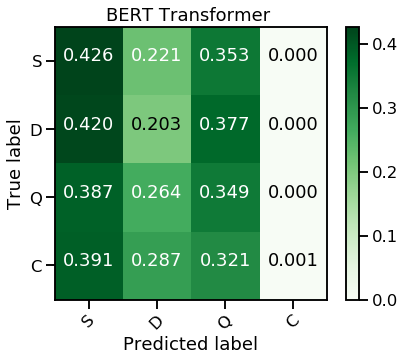

Test_ acc: 0.07933398628795299
Test_ f1 none: [0.123 0.08  0.167 0.003]
Test_ f1 macro: 0.09324544009433246
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.167 	F-macro_val: 0.146
Epoch 20 	acc_val: 0.222 	F-macro_val: 0.191
Epoch 30 	acc_val: 0.233 	F-macro_val: 0.216
Epoch 40 	acc_val: 0.264 	F-macro_val: 0.239
Epoch 50 	acc_val: 0.292 	F-macro_val: 0.280
Epoch 60 	acc_val: 0.309 	F-macro_val: 0.289
Epoch 70 	acc_val: 0.330 	F-macro_val: 0.304
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


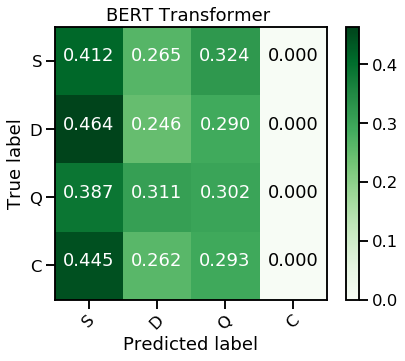

Test_ acc: 0.07541625857002938
Test_ f1 none: [0.109 0.1   0.157 0.   ]
Test_ f1 macro: 0.09132683851093609
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.351 	F-macro_val: 0.266
Epoch 10 	acc_val: 0.174 	F-macro_val: 0.152
Epoch 20 	acc_val: 0.229 	F-macro_val: 0.201
Epoch 30 	acc_val: 0.257 	F-macro_val: 0.241
Epoch 40 	acc_val: 0.278 	F-macro_val: 0.259
Epoch 50 	acc_val: 0.306 	F-macro_val: 0.278
Epoch 60 	acc_val: 0.299 	F-macro_val: 0.294
Epoch 70 	acc_val: 0.292 	F-macro_val: 0.271
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


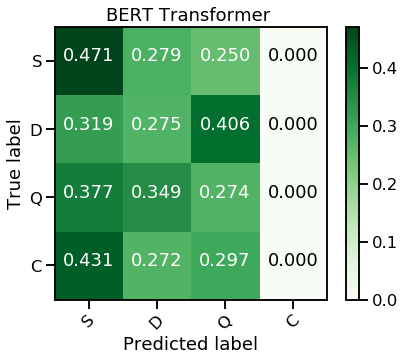

Test_ acc: 0.07835455435847209
Test_ f1 none: [0.129 0.107 0.141 0.   ]
Test_ f1 macro: 0.09415835756494735
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.299 	F-macro_val: 0.218
Epoch 10 	acc_val: 0.205 	F-macro_val: 0.164
Epoch 20 	acc_val: 0.243 	F-macro_val: 0.223
Epoch 30 	acc_val: 0.281 	F-macro_val: 0.264
Epoch 40 	acc_val: 0.288 	F-macro_val: 0.267
Epoch 50 	acc_val: 0.288 	F-macro_val: 0.266
Epoch 60 	acc_val: 0.344 	F-macro_val: 0.313
Epoch 70 	acc_val: 0.326 	F-macro_val: 0.302
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


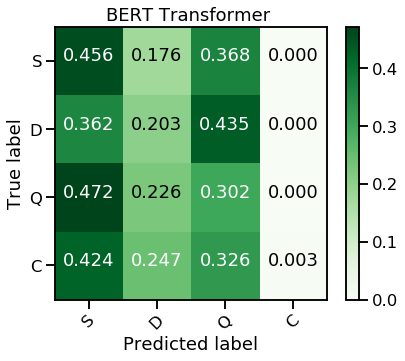

Test_ acc: 0.07737512242899118
Test_ f1 none: [0.123 0.09  0.143 0.005]
Test_ f1 macro: 0.09033824156641869
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.176
Epoch 10 	acc_val: 0.153 	F-macro_val: 0.130
Epoch 20 	acc_val: 0.205 	F-macro_val: 0.182
Epoch 30 	acc_val: 0.253 	F-macro_val: 0.231
Epoch 40 	acc_val: 0.278 	F-macro_val: 0.265
Epoch 50 	acc_val: 0.295 	F-macro_val: 0.279
Epoch 60 	acc_val: 0.312 	F-macro_val: 0.293
Epoch 70 	acc_val: 0.319 	F-macro_val: 0.294
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


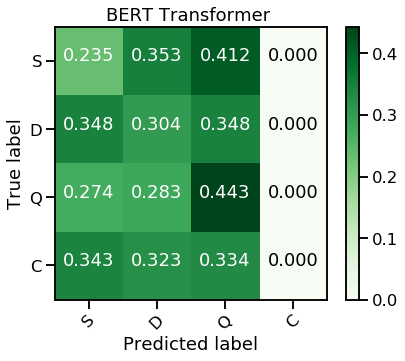

Test_ acc: 0.08227228207639568
Test_ f1 none: [0.079 0.106 0.202 0.   ]
Test_ f1 macro: 0.0969218930876346
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.194
Epoch 10 	acc_val: 0.188 	F-macro_val: 0.149
Epoch 20 	acc_val: 0.219 	F-macro_val: 0.184
Epoch 30 	acc_val: 0.278 	F-macro_val: 0.253
Epoch 40 	acc_val: 0.295 	F-macro_val: 0.273
Epoch 50 	acc_val: 0.302 	F-macro_val: 0.271
Epoch 60 	acc_val: 0.295 	F-macro_val: 0.271
Epoch 70 	acc_val: 0.309 	F-macro_val: 0.283
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


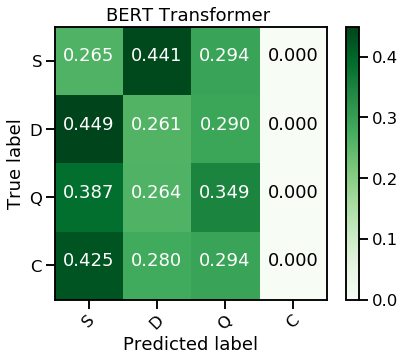

Test_ acc: 0.07149853085210578
Test_ f1 none: [0.074 0.099 0.18  0.   ]
Test_ f1 macro: 0.0881012090265714
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.182
Epoch 10 	acc_val: 0.170 	F-macro_val: 0.129
Epoch 20 	acc_val: 0.219 	F-macro_val: 0.195
Epoch 30 	acc_val: 0.257 	F-macro_val: 0.238
Epoch 40 	acc_val: 0.264 	F-macro_val: 0.254
Epoch 50 	acc_val: 0.306 	F-macro_val: 0.287
Epoch 60 	acc_val: 0.319 	F-macro_val: 0.291
Epoch 70 	acc_val: 0.316 	F-macro_val: 0.295
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


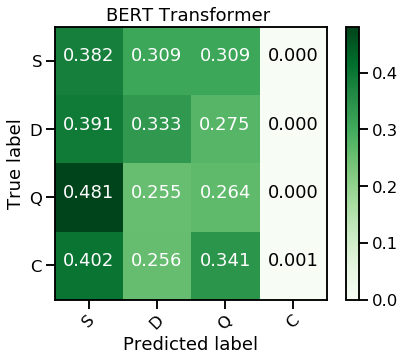

Test_ acc: 0.07639569049951028
Test_ f1 none: [0.107 0.136 0.128 0.003]
Test_ f1 macro: 0.09325993666215199
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.250 	F-macro_val: 0.223
Epoch 10 	acc_val: 0.188 	F-macro_val: 0.168
Epoch 20 	acc_val: 0.236 	F-macro_val: 0.203
Epoch 30 	acc_val: 0.267 	F-macro_val: 0.240
Epoch 40 	acc_val: 0.274 	F-macro_val: 0.248
Epoch 50 	acc_val: 0.281 	F-macro_val: 0.256
Epoch 60 	acc_val: 0.316 	F-macro_val: 0.282
Epoch 70 	acc_val: 0.333 	F-macro_val: 0.299
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


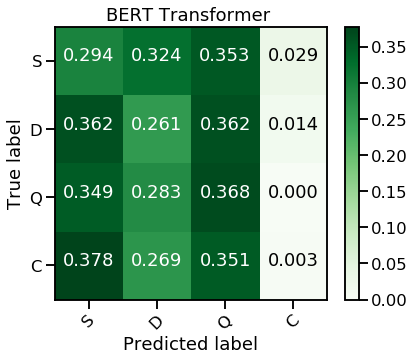

Test_ acc: 0.07737512242899118
Test_ f1 none: [0.09  0.103 0.167 0.005]
Test_ f1 macro: 0.09141761934717706
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.302 	F-macro_val: 0.179
Epoch 10 	acc_val: 0.156 	F-macro_val: 0.142
Epoch 20 	acc_val: 0.219 	F-macro_val: 0.210
Epoch 30 	acc_val: 0.253 	F-macro_val: 0.240
Epoch 40 	acc_val: 0.292 	F-macro_val: 0.284
Epoch 50 	acc_val: 0.292 	F-macro_val: 0.282
Epoch 60 	acc_val: 0.330 	F-macro_val: 0.315
Epoch 70 	acc_val: 0.319 	F-macro_val: 0.306
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


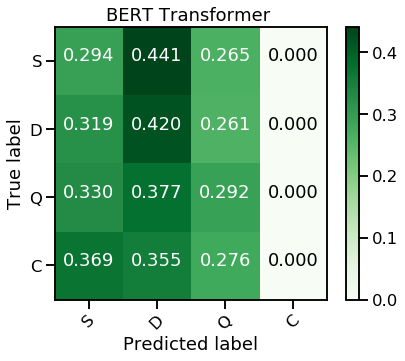

Test_ acc: 0.07835455435847209
Test_ f1 none: [0.093 0.131 0.16  0.   ]
Test_ f1 macro: 0.09575425941405324
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.156 	F-macro_val: 0.147
Epoch 10 	acc_val: 0.177 	F-macro_val: 0.155
Epoch 20 	acc_val: 0.219 	F-macro_val: 0.197
Epoch 30 	acc_val: 0.257 	F-macro_val: 0.232
Epoch 40 	acc_val: 0.281 	F-macro_val: 0.252
Epoch 50 	acc_val: 0.309 	F-macro_val: 0.274
Epoch 60 	acc_val: 0.309 	F-macro_val: 0.277
Epoch 70 	acc_val: 0.288 	F-macro_val: 0.269
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


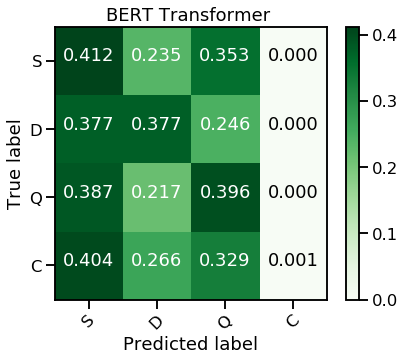

Test_ acc: 0.09500489715964741
Test_ f1 none: [0.117 0.152 0.189 0.003]
Test_ f1 macro: 0.11530613173693162


Nuevo best encontrado:

Acc: 0.095 	F1-ma: 0.115
	F1-none:  [0.117 0.152 0.189 0.003]
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.205 	F-macro_val: 0.156
Epoch 10 	acc_val: 0.153 	F-macro_val: 0.121
Epoch 20 	acc_val: 0.219 	F-macro_val: 0.201
Epoch 30 	acc_val: 0.240 	F-macro_val: 0.219
Epoch 40 	acc_val: 0.299 	F-macro_val: 0.264
Epoch 50 	acc_val: 0.319 	F-macro_val: 0.275
Epoch 60 	acc_val: 0.309 	F-macro_val: 0.278
Epoch 70 	acc_val: 0.312 	F-macro_val: 0.280
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


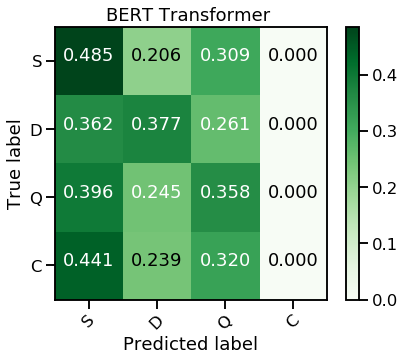

Test_ acc: 0.09500489715964741
Test_ f1 none: [0.129 0.162 0.176 0.   ]
Test_ f1 macro: 0.11676955202912187


Nuevo best encontrado:

Acc: 0.095 	F1-ma: 0.117
	F1-none:  [0.129 0.162 0.176 0.   ]
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.205 	F-macro_val: 0.146
Epoch 10 	acc_val: 0.135 	F-macro_val: 0.130
Epoch 20 	acc_val: 0.212 	F-macro_val: 0.195
Epoch 30 	acc_val: 0.236 	F-macro_val: 0.223
Epoch 40 	acc_val: 0.288 	F-macro_val: 0.260
Epoch 50 	acc_val: 0.295 	F-macro_val: 0.268
Epoch 60 	acc_val: 0.306 	F-macro_val: 0.286
Epoch 70 	acc_val: 0.312 	F-macro_val: 0.294
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


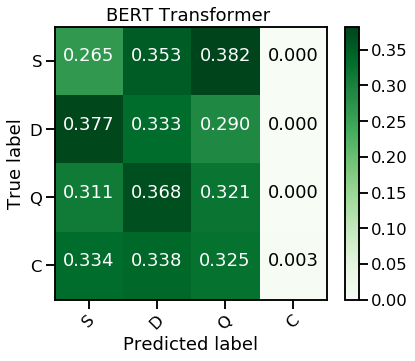

Test_ acc: 0.07541625857002938
Test_ f1 none: [0.089 0.11  0.155 0.005]
Test_ f1 macro: 0.08974060880307133
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.222 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.181 	F-macro_val: 0.164
Epoch 20 	acc_val: 0.205 	F-macro_val: 0.185
Epoch 30 	acc_val: 0.236 	F-macro_val: 0.216
Epoch 40 	acc_val: 0.267 	F-macro_val: 0.250
Epoch 50 	acc_val: 0.281 	F-macro_val: 0.272
Epoch 60 	acc_val: 0.288 	F-macro_val: 0.272
Epoch 70 	acc_val: 0.302 	F-macro_val: 0.282
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


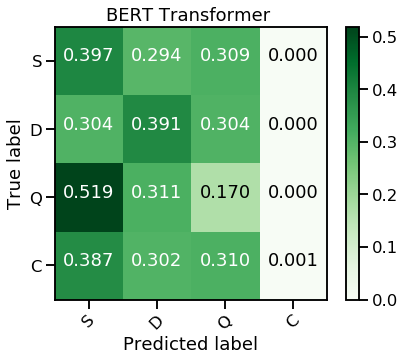

Test_ acc: 0.07149853085210578
Test_ f1 none: [0.114 0.141 0.088 0.003]
Test_ f1 macro: 0.08651281555202475
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.201 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.167 	F-macro_val: 0.160
Epoch 20 	acc_val: 0.226 	F-macro_val: 0.210
Epoch 30 	acc_val: 0.247 	F-macro_val: 0.238
Epoch 40 	acc_val: 0.281 	F-macro_val: 0.269
Epoch 50 	acc_val: 0.285 	F-macro_val: 0.268
Epoch 60 	acc_val: 0.312 	F-macro_val: 0.296
Epoch 70 	acc_val: 0.326 	F-macro_val: 0.305
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


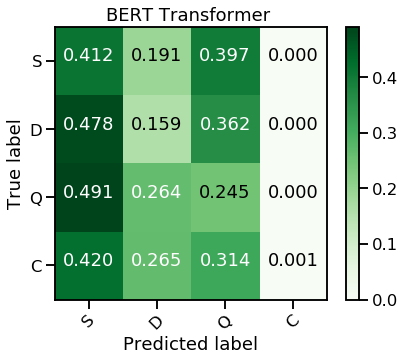

Test_ acc: 0.06464250734573947
Test_ f1 none: [0.11  0.067 0.121 0.003]
Test_ f1 macro: 0.07539430728300299
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.163 	F-macro_val: 0.140
Epoch 20 	acc_val: 0.226 	F-macro_val: 0.186
Epoch 30 	acc_val: 0.247 	F-macro_val: 0.217
Epoch 40 	acc_val: 0.274 	F-macro_val: 0.240
Epoch 50 	acc_val: 0.292 	F-macro_val: 0.250
Epoch 60 	acc_val: 0.288 	F-macro_val: 0.253
Epoch 70 	acc_val: 0.295 	F-macro_val: 0.271
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


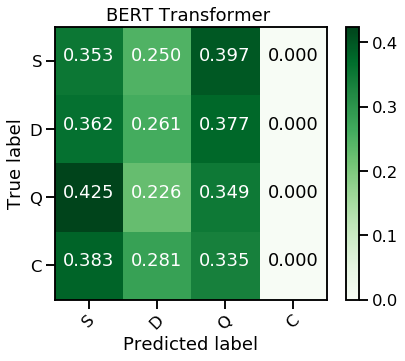

Test_ acc: 0.07737512242899118
Test_ f1 none: [0.104 0.104 0.162 0.   ]
Test_ f1 macro: 0.09250495638300701
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.177 	F-macro_val: 0.133
Epoch 10 	acc_val: 0.156 	F-macro_val: 0.132
Epoch 20 	acc_val: 0.208 	F-macro_val: 0.183
Epoch 30 	acc_val: 0.247 	F-macro_val: 0.229
Epoch 40 	acc_val: 0.306 	F-macro_val: 0.270
Epoch 50 	acc_val: 0.312 	F-macro_val: 0.286
Epoch 60 	acc_val: 0.302 	F-macro_val: 0.280
Epoch 70 	acc_val: 0.326 	F-macro_val: 0.293
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


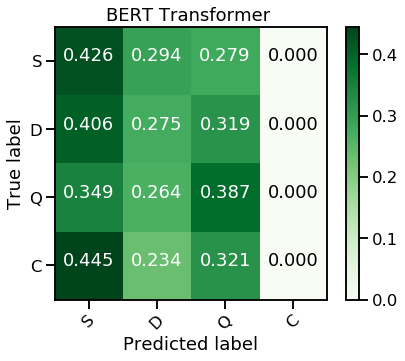

Test_ acc: 0.0871694417238002
Test_ f1 none: [0.114 0.119 0.187 0.   ]
Test_ f1 macro: 0.10522117389112869
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.309 	F-macro_val: 0.231
Epoch 10 	acc_val: 0.188 	F-macro_val: 0.165
Epoch 20 	acc_val: 0.208 	F-macro_val: 0.197
Epoch 30 	acc_val: 0.260 	F-macro_val: 0.239
Epoch 40 	acc_val: 0.278 	F-macro_val: 0.253
Epoch 50 	acc_val: 0.281 	F-macro_val: 0.258
Epoch 60 	acc_val: 0.267 	F-macro_val: 0.246
Epoch 70 	acc_val: 0.299 	F-macro_val: 0.272
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


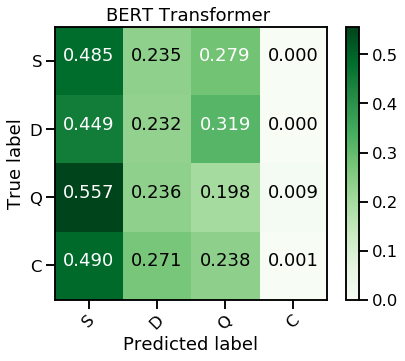

Test_ acc: 0.06953966699314397
Test_ f1 none: [0.115 0.095 0.119 0.003]
Test_ f1 macro: 0.08297109438365816


In [66]:
best_0cw, all_accs_0cw, all_fno_0cw, all_ma_0cw, all_cm_0cw =train_transformer(0.0, 75, path_a, path_m, "Greens", class_weights=class_weights)

In [67]:
print ("best_0cw", best_0cw)
print ("all_accs_0cw", all_accs_0cw)
print ("all_fno_0cw", all_fno_0cw)
print ("all_ma_0cw", all_ma_0cw)

best_0cw {'F_ma': 0.11676955202912187, 'Run': 14}
all_accs_0cw [0.07247796278158668, 0.06660137120470128, 0.0910871694417238, 0.07933398628795299, 0.07541625857002938, 0.07835455435847209, 0.07737512242899118, 0.08227228207639568, 0.07149853085210578, 0.07639569049951028, 0.07737512242899118, 0.07835455435847209, 0.09500489715964741, 0.09500489715964741, 0.07541625857002938, 0.07149853085210578, 0.06464250734573947, 0.07737512242899118, 0.0871694417238002, 0.06953966699314397]
all_fno_0cw [array([0.103, 0.107, 0.141, 0.   ]), array([0.093, 0.096, 0.132, 0.   ]), array([0.132, 0.096, 0.2  , 0.   ]), array([0.123, 0.08 , 0.167, 0.003]), array([0.109, 0.1  , 0.157, 0.   ]), array([0.129, 0.107, 0.141, 0.   ]), array([0.123, 0.09 , 0.143, 0.005]), array([0.079, 0.106, 0.202, 0.   ]), array([0.074, 0.099, 0.18 , 0.   ]), array([0.107, 0.136, 0.128, 0.003]), array([0.09 , 0.103, 0.167, 0.005]), array([0.093, 0.131, 0.16 , 0.   ]), array([0.117, 0.152, 0.189, 0.003]), array([0.129, 0.162, 0.1

Acc: 0.078 -- deviation: 0.008
F-score: 0.094 -- deviation: 0.010
(0.0cw) SDQC: 0.10739154299230144 0.11007329012552394 0.1557607686856201 0.0015383020064087748


Confusion counts
[[5.150e+02 3.890e+02 4.540e+02 2.000e+00]
 [5.290e+02 3.930e+02 4.570e+02 1.000e+00]
 [8.610e+02 5.820e+02 6.750e+02 2.000e+00]
 [6.257e+03 4.380e+03 4.911e+03 1.200e+01]]


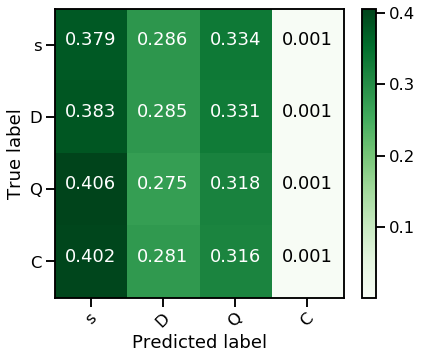

In [68]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_0cw)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_0cw)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_0cw)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_0cw)[:,0])
den=np.mean(np.asarray(all_fno_0cw)[:,1])
que=np.mean(np.asarray(all_fno_0cw)[:,2])
com=np.mean(np.asarray(all_fno_0cw)[:,3])

print ("(0.0cw) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_0cw:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["s", "D", "Q", "C"], "", cmap='Greens')

## Con aumento de datos

### 0.15

In [69]:
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0]) 

print ("Pesos de clases:", class_weights)

Pesos de clases: [1. 1. 1. 1.]


Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.175
Epoch 10 	acc_val: 0.399 	F-macro_val: 0.288
Epoch 20 	acc_val: 0.365 	F-macro_val: 0.293
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


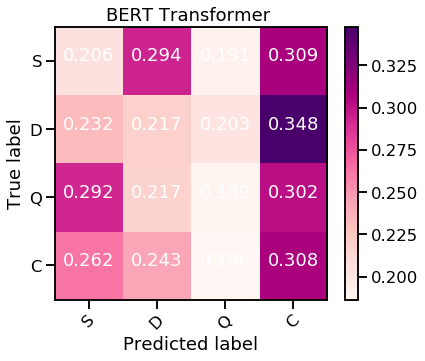

Test_ acc: 0.28305582761998044
Test_ f1 none: [0.084 0.095 0.134 0.438]
Test_ f1 macro: 0.18790128631196706


Nuevo best encontrado:

Acc: 0.283 	F1-ma: 0.188
	F1-none:  [0.084 0.095 0.134 0.438]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.207
Epoch 10 	acc_val: 0.358 	F-macro_val: 0.278
Epoch 20 	acc_val: 0.323 	F-macro_val: 0.270
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


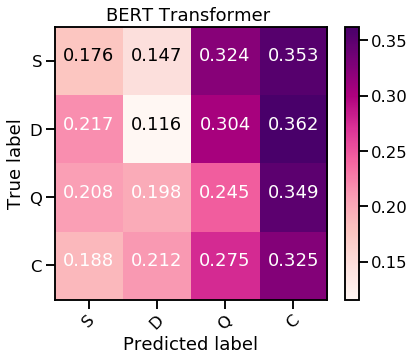

Test_ acc: 0.29285014691478944
Test_ f1 none: [0.091 0.059 0.134 0.453]
Test_ f1 macro: 0.18413450218740224
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.178
Epoch 10 	acc_val: 0.330 	F-macro_val: 0.248
Epoch 20 	acc_val: 0.378 	F-macro_val: 0.313
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


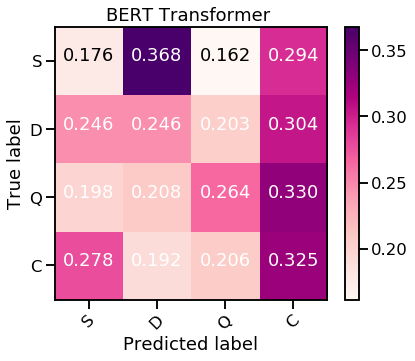

Test_ acc: 0.3036238981390793
Test_ f1 none: [0.072 0.121 0.176 0.457]
Test_ f1 macro: 0.20626587255810244


Nuevo best encontrado:

Acc: 0.304 	F1-ma: 0.206
	F1-none:  [0.072 0.121 0.176 0.457]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.201 	F-macro_val: 0.158
Epoch 10 	acc_val: 0.382 	F-macro_val: 0.274
Epoch 20 	acc_val: 0.403 	F-macro_val: 0.306
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


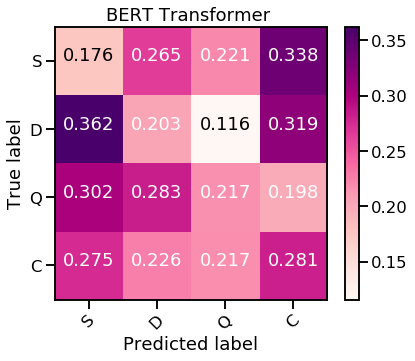

Test_ acc: 0.2624877571008815
Test_ f1 none: [0.068 0.091 0.143 0.412]
Test_ f1 macro: 0.17873121326844854
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.260 	F-macro_val: 0.170
Epoch 10 	acc_val: 0.358 	F-macro_val: 0.262
Epoch 20 	acc_val: 0.399 	F-macro_val: 0.298
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


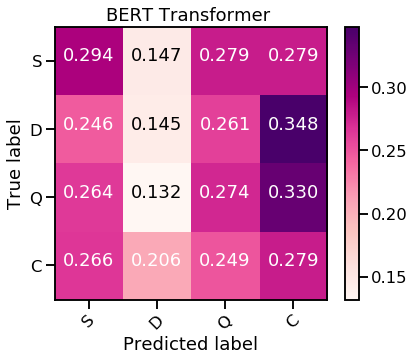

Test_ acc: 0.2703232125367287
Test_ f1 none: [0.118 0.076 0.158 0.404]
Test_ f1 macro: 0.18915901762783602
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.191
Epoch 10 	acc_val: 0.295 	F-macro_val: 0.218
Epoch 20 	acc_val: 0.365 	F-macro_val: 0.262
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


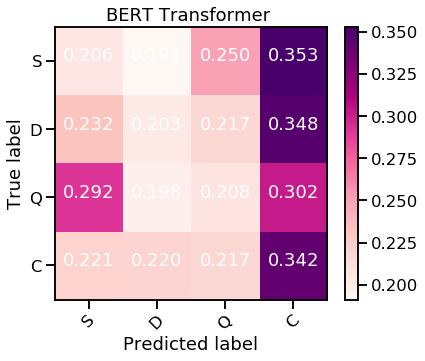

Test_ acc: 0.3095004897159647
Test_ f1 none: [0.093 0.097 0.134 0.473]
Test_ f1 macro: 0.1993234221002023
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.153 	F-macro_val: 0.128
Epoch 10 	acc_val: 0.347 	F-macro_val: 0.284
Epoch 20 	acc_val: 0.292 	F-macro_val: 0.240
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


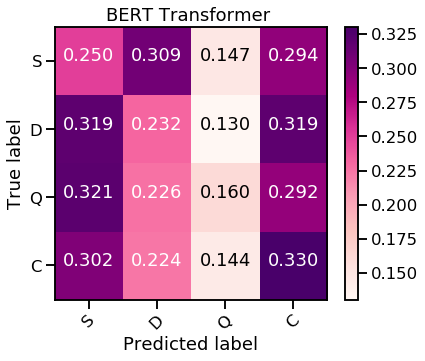

Test_ acc: 0.3006856023506366
Test_ f1 none: [0.09  0.105 0.134 0.464]
Test_ f1 macro: 0.19836146862341875
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.192
Epoch 10 	acc_val: 0.372 	F-macro_val: 0.287
Epoch 20 	acc_val: 0.417 	F-macro_val: 0.308
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


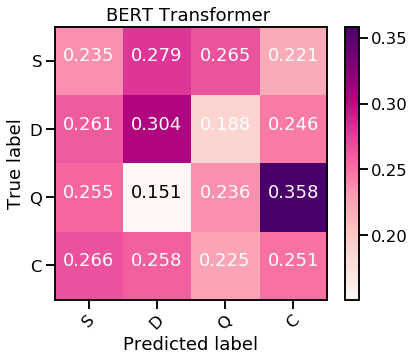

Test_ acc: 0.2517140058765916
Test_ f1 none: [0.095 0.129 0.148 0.374]
Test_ f1 macro: 0.18659044605534034
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.219 	F-macro_val: 0.173
Epoch 10 	acc_val: 0.333 	F-macro_val: 0.256
Epoch 20 	acc_val: 0.399 	F-macro_val: 0.303
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


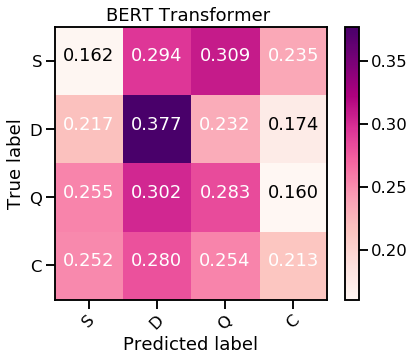

Test_ acc: 0.22820763956904996
Test_ f1 none: [0.069 0.142 0.162 0.336]
Test_ f1 macro: 0.1773210176329511
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.200
Epoch 10 	acc_val: 0.372 	F-macro_val: 0.295
Epoch 20 	acc_val: 0.451 	F-macro_val: 0.367
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


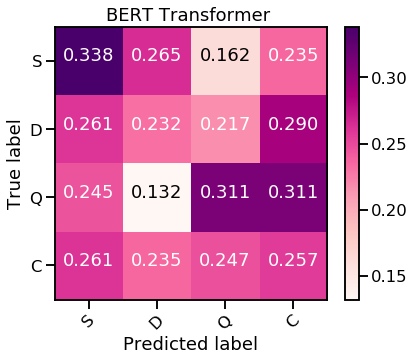

Test_ acc: 0.2664054848188051
Test_ f1 none: [0.136 0.107 0.185 0.382]
Test_ f1 macro: 0.20241980646381064
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.285 	F-macro_val: 0.236
Epoch 10 	acc_val: 0.375 	F-macro_val: 0.254
Epoch 20 	acc_val: 0.444 	F-macro_val: 0.320
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


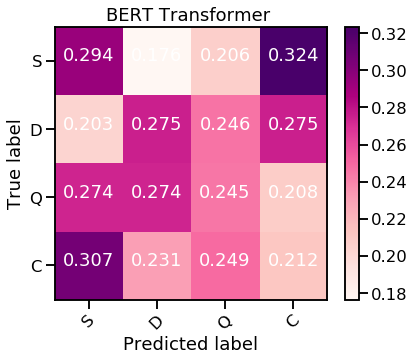

Test_ acc: 0.22526934378060726
Test_ f1 none: [0.108 0.123 0.146 0.328]
Test_ f1 macro: 0.17619388170921915
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.193
Epoch 10 	acc_val: 0.344 	F-macro_val: 0.246
Epoch 20 	acc_val: 0.382 	F-macro_val: 0.262
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


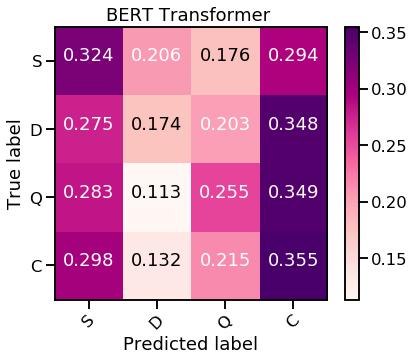

Test_ acc: 0.33006856023506365
Test_ f1 none: [0.119 0.114 0.166 0.486]
Test_ f1 macro: 0.22121797028724582


Nuevo best encontrado:

Acc: 0.330 	F1-ma: 0.221
	F1-none:  [0.119 0.114 0.166 0.486]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.180
Epoch 10 	acc_val: 0.375 	F-macro_val: 0.291
Epoch 20 	acc_val: 0.444 	F-macro_val: 0.308
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


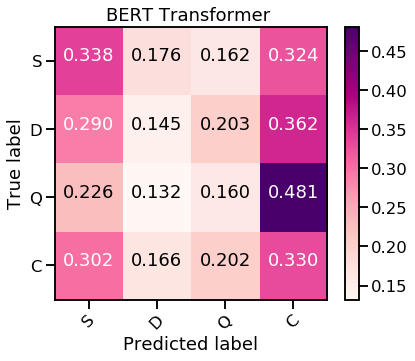

Test_ acc: 0.3006856023506366
Test_ f1 none: [0.124 0.085 0.111 0.454]
Test_ f1 macro: 0.19373316541070798
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.302 	F-macro_val: 0.225
Epoch 10 	acc_val: 0.351 	F-macro_val: 0.283
Epoch 20 	acc_val: 0.403 	F-macro_val: 0.320
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


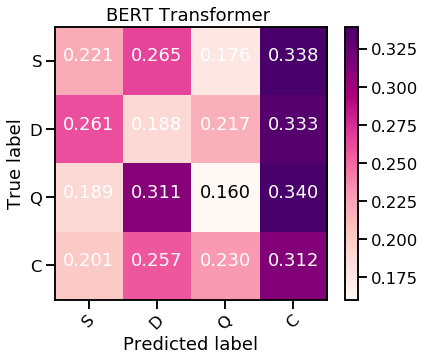

Test_ acc: 0.2820763956904995
Test_ f1 none: [0.108 0.078 0.103 0.441]
Test_ f1 macro: 0.1825853231686132
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.174
Epoch 10 	acc_val: 0.378 	F-macro_val: 0.293
Epoch 20 	acc_val: 0.389 	F-macro_val: 0.309
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


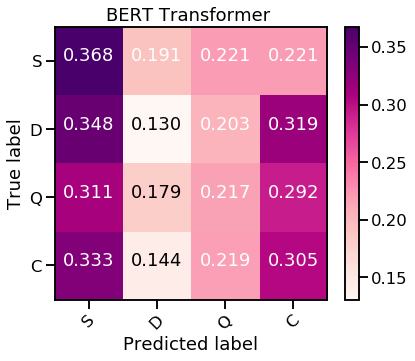

Test_ acc: 0.28795298726738494
Test_ f1 none: [0.122 0.081 0.14  0.438]
Test_ f1 macro: 0.19531187561676688
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.226 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.236
Epoch 20 	acc_val: 0.389 	F-macro_val: 0.312
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


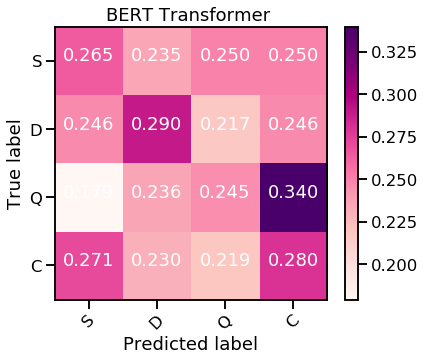

Test_ acc: 0.2761998041136141
Test_ f1 none: [0.108 0.129 0.156 0.409]
Test_ f1 macro: 0.20056304939203126
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.213
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.258
Epoch 20 	acc_val: 0.316 	F-macro_val: 0.252
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


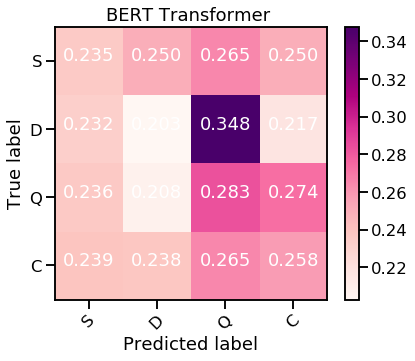

Test_ acc: 0.2556317335945152
Test_ f1 none: [0.103 0.091 0.156 0.387]
Test_ f1 macro: 0.18422189098502179
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.162
Epoch 10 	acc_val: 0.326 	F-macro_val: 0.231
Epoch 20 	acc_val: 0.365 	F-macro_val: 0.292
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


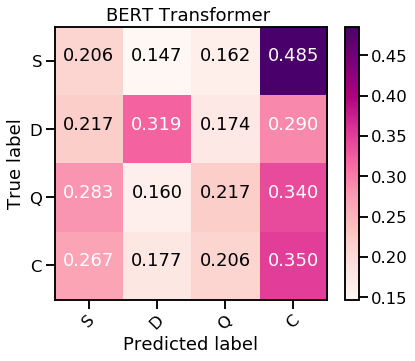

Test_ acc: 0.32419196865817823
Test_ f1 none: [0.084 0.172 0.147 0.478]
Test_ f1 macro: 0.2201262318216609
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.177 	F-macro_val: 0.166
Epoch 10 	acc_val: 0.351 	F-macro_val: 0.269
Epoch 20 	acc_val: 0.399 	F-macro_val: 0.303
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


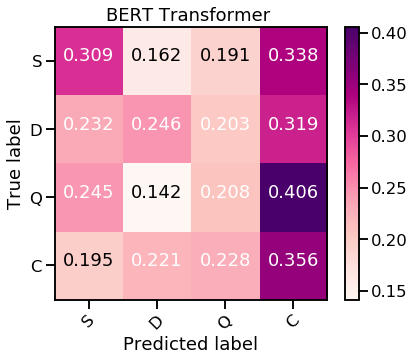

Test_ acc: 0.33006856023506365
Test_ f1 none: [0.148 0.12  0.133 0.485]
Test_ f1 macro: 0.2213369345393219


Nuevo best encontrado:

Acc: 0.330 	F1-ma: 0.221
	F1-none:  [0.148 0.12  0.133 0.485]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.240 	F-macro_val: 0.184
Epoch 10 	acc_val: 0.358 	F-macro_val: 0.267
Epoch 20 	acc_val: 0.333 	F-macro_val: 0.262
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


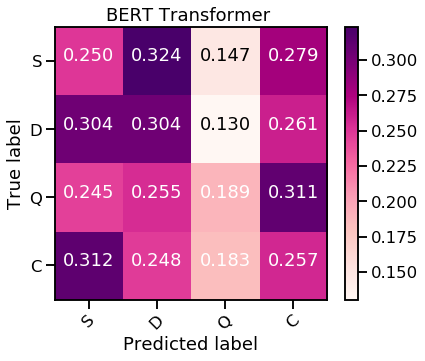

Test_ acc: 0.25269343780607245
Test_ f1 none: [0.091 0.127 0.139 0.382]
Test_ f1 macro: 0.1845562255939202


In [70]:
best_15, all_accs_15, all_fno_15, all_ma_15, all_cm_15 = train_transformer(0.15, 30, path_a, path_m, "RdPu", augmented=True)


In [71]:
print ("best_15", best_15)
print ("all_accs_15", all_accs_15)
print ("all_fno_15", all_fno_15)
print ("all_ma_15", all_ma_15)

best_15 {'F_ma': 0.2213369345393219, 'Run': 19}
all_accs_15 [0.28305582761998044, 0.29285014691478944, 0.3036238981390793, 0.2624877571008815, 0.2703232125367287, 0.3095004897159647, 0.3006856023506366, 0.2517140058765916, 0.22820763956904996, 0.2664054848188051, 0.22526934378060726, 0.33006856023506365, 0.3006856023506366, 0.2820763956904995, 0.28795298726738494, 0.2761998041136141, 0.2556317335945152, 0.32419196865817823, 0.33006856023506365, 0.25269343780607245]
all_fno_15 [array([0.084, 0.095, 0.134, 0.438]), array([0.091, 0.059, 0.134, 0.453]), array([0.072, 0.121, 0.176, 0.457]), array([0.068, 0.091, 0.143, 0.412]), array([0.118, 0.076, 0.158, 0.404]), array([0.093, 0.097, 0.134, 0.473]), array([0.09 , 0.105, 0.134, 0.464]), array([0.095, 0.129, 0.148, 0.374]), array([0.069, 0.142, 0.162, 0.336]), array([0.136, 0.107, 0.185, 0.382]), array([0.108, 0.123, 0.146, 0.328]), array([0.119, 0.114, 0.166, 0.486]), array([0.124, 0.085, 0.111, 0.454]), array([0.108, 0.078, 0.103, 0.441]), 

Acc: 0.282 -- deviation: 0.030
F-score: 0.195 -- deviation: 0.014
(0.15) SDQC: 0.1016322271013 0.10712309137787801 0.14527157551257908 0.4239840262790405


Confusion counts
[[ 342.  319.  290.  409.]
 [ 359.  314.  291.  416.]
 [ 541.  430.  484.  665.]
 [4121. 3377. 3450. 4612.]]


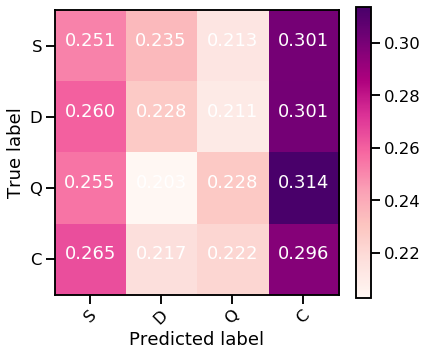

In [72]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_15)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_15)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_15)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_15)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_15)[:,0])
den=np.mean(np.asarray(all_fno_15)[:,1])
que=np.mean(np.asarray(all_fno_15)[:,2])
com=np.mean(np.asarray(all_fno_15)[:,3])

print ("(0.15) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_15:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S", "D", "Q", "C"], "", cmap='RdPu')

## 0.5 mask

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.271 	F-macro_val: 0.194
Epoch 10 	acc_val: 0.344 	F-macro_val: 0.279
Epoch 20 	acc_val: 0.455 	F-macro_val: 0.327
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


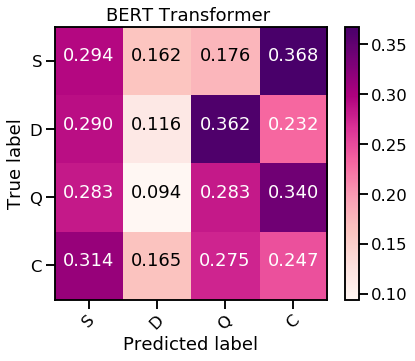

Test_ acc: 0.24485798237022527
Test_ f1 none: [0.105 0.071 0.155 0.367]
Test_ f1 macro: 0.17432735985054004


Nuevo best encontrado:

Acc: 0.245 	F1-ma: 0.174
	F1-none:  [0.105 0.071 0.155 0.367]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.250 	F-macro_val: 0.178
Epoch 10 	acc_val: 0.361 	F-macro_val: 0.269
Epoch 20 	acc_val: 0.372 	F-macro_val: 0.294
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


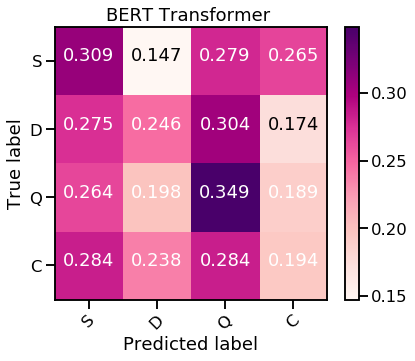

Test_ acc: 0.22135161606268364
Test_ f1 none: [0.118 0.113 0.183 0.308]
Test_ f1 macro: 0.18046904898182092


Nuevo best encontrado:

Acc: 0.221 	F1-ma: 0.180
	F1-none:  [0.118 0.113 0.183 0.308]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.198 	F-macro_val: 0.153
Epoch 10 	acc_val: 0.288 	F-macro_val: 0.208
Epoch 20 	acc_val: 0.337 	F-macro_val: 0.291
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


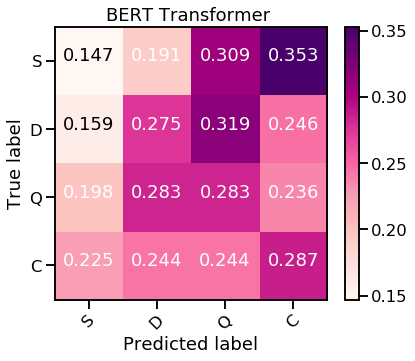

Test_ acc: 0.2761998041136141
Test_ f1 none: [0.07  0.118 0.163 0.418]
Test_ f1 macro: 0.19228787591882768


Nuevo best encontrado:

Acc: 0.276 	F1-ma: 0.192
	F1-none:  [0.07  0.118 0.163 0.418]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.295 	F-macro_val: 0.209
Epoch 10 	acc_val: 0.302 	F-macro_val: 0.255
Epoch 20 	acc_val: 0.444 	F-macro_val: 0.282
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


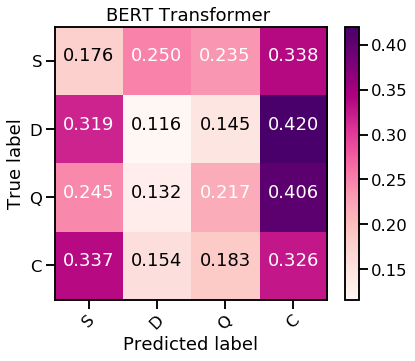

Test_ acc: 0.2908912830558276
Test_ f1 none: [0.062 0.07  0.155 0.451]
Test_ f1 macro: 0.1843375674366194
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.278 	F-macro_val: 0.223
Epoch 10 	acc_val: 0.368 	F-macro_val: 0.292
Epoch 20 	acc_val: 0.358 	F-macro_val: 0.272
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


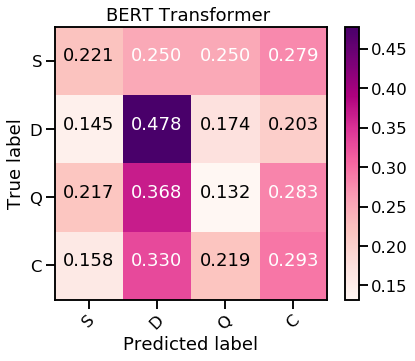

Test_ acc: 0.2840352595494613
Test_ f1 none: [0.126 0.159 0.088 0.427]
Test_ f1 macro: 0.1997250841851641


Nuevo best encontrado:

Acc: 0.284 	F1-ma: 0.200
	F1-none:  [0.126 0.159 0.088 0.427]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.188 	F-macro_val: 0.142
Epoch 10 	acc_val: 0.312 	F-macro_val: 0.215
Epoch 20 	acc_val: 0.372 	F-macro_val: 0.296
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


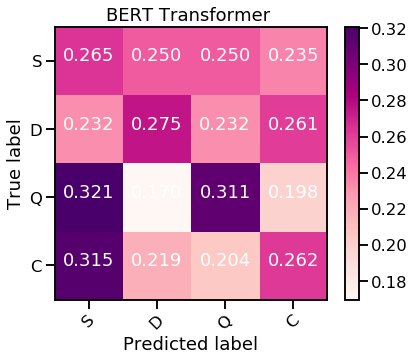

Test_ acc: 0.2683643486777669
Test_ f1 none: [0.094 0.13  0.199 0.393]
Test_ f1 macro: 0.204254853771113


Nuevo best encontrado:

Acc: 0.268 	F1-ma: 0.204
	F1-none:  [0.094 0.13  0.199 0.393]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.260 	F-macro_val: 0.202
Epoch 10 	acc_val: 0.368 	F-macro_val: 0.276
Epoch 20 	acc_val: 0.441 	F-macro_val: 0.317
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


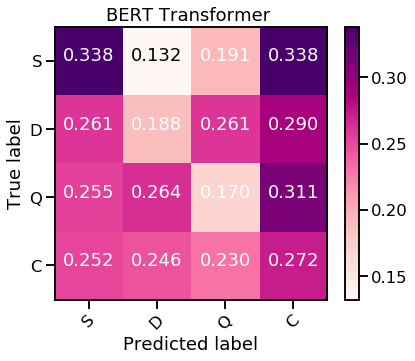

Test_ acc: 0.2605288932419197
Test_ f1 none: [0.139 0.084 0.108 0.398]
Test_ f1 macro: 0.1819895521544185
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.177
Epoch 10 	acc_val: 0.333 	F-macro_val: 0.241
Epoch 20 	acc_val: 0.406 	F-macro_val: 0.289
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


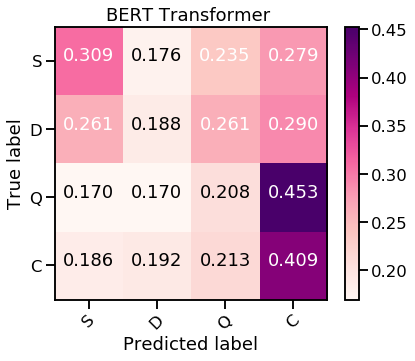

Test_ acc: 0.366307541625857
Test_ f1 none: [0.156 0.1   0.134 0.538]
Test_ f1 macro: 0.23173374629511007


Nuevo best encontrado:

Acc: 0.366 	F1-ma: 0.232
	F1-none:  [0.156 0.1   0.134 0.538]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.295 	F-macro_val: 0.214
Epoch 10 	acc_val: 0.358 	F-macro_val: 0.263
Epoch 20 	acc_val: 0.410 	F-macro_val: 0.288
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


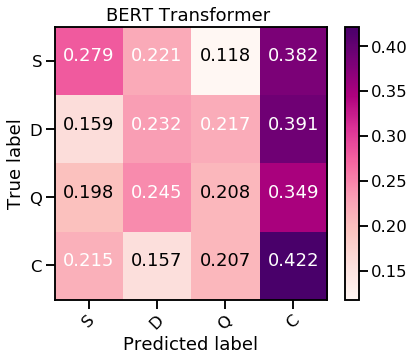

Test_ acc: 0.3770812928501469
Test_ f1 none: [0.133 0.129 0.141 0.548]
Test_ f1 macro: 0.2378550038087205


Nuevo best encontrado:

Acc: 0.377 	F1-ma: 0.238
	F1-none:  [0.133 0.129 0.141 0.548]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.233 	F-macro_val: 0.188
Epoch 10 	acc_val: 0.316 	F-macro_val: 0.260
Epoch 20 	acc_val: 0.396 	F-macro_val: 0.323
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


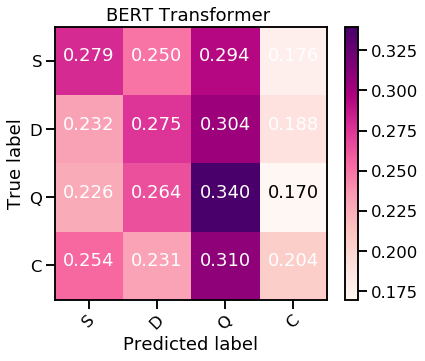

Test_ acc: 0.22820763956904996
Test_ f1 none: [0.117 0.121 0.17  0.324]
Test_ f1 macro: 0.18315748609872082
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 11
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.243 	F-macro_val: 0.201
Epoch 10 	acc_val: 0.319 	F-macro_val: 0.246
Epoch 20 	acc_val: 0.378 	F-macro_val: 0.312
Testing run # 11
SE TUVIERON QUE REPETIR 3 EJEMPLOS


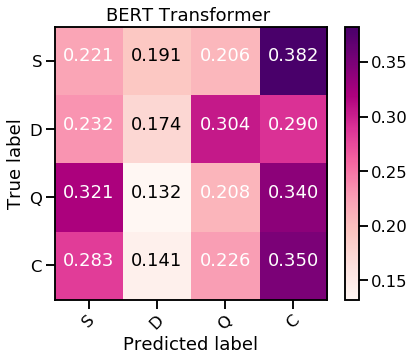

Test_ acc: 0.3143976493633692
Test_ f1 none: [0.085 0.11  0.13  0.481]
Test_ f1 macro: 0.20135911504063397
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 12
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.312 	F-macro_val: 0.194
Epoch 10 	acc_val: 0.354 	F-macro_val: 0.252
Epoch 20 	acc_val: 0.431 	F-macro_val: 0.348
Testing run # 12
SE TUVIERON QUE REPETIR 3 EJEMPLOS


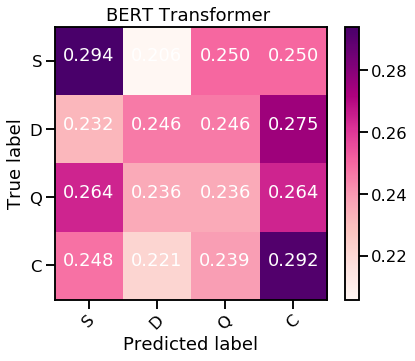

Test_ acc: 0.28305582761998044
Test_ f1 none: [0.123 0.114 0.142 0.425]
Test_ f1 macro: 0.20117528938857285
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 13
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.344 	F-macro_val: 0.255
Epoch 10 	acc_val: 0.333 	F-macro_val: 0.253
Epoch 20 	acc_val: 0.420 	F-macro_val: 0.285
Testing run # 13
SE TUVIERON QUE REPETIR 3 EJEMPLOS


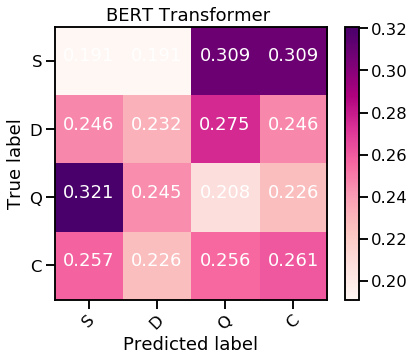

Test_ acc: 0.24877571008814886
Test_ f1 none: [0.078 0.107 0.12  0.389]
Test_ f1 macro: 0.17353316820488618
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 14
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.181 	F-macro_val: 0.155
Epoch 10 	acc_val: 0.319 	F-macro_val: 0.256
Epoch 20 	acc_val: 0.368 	F-macro_val: 0.296
Testing run # 14
SE TUVIERON QUE REPETIR 3 EJEMPLOS


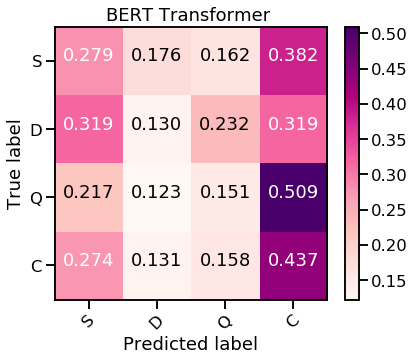

Test_ acc: 0.376101860920666
Test_ f1 none: [0.11  0.088 0.118 0.557]
Test_ f1 macro: 0.21824347839721742
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 15
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.295 	F-macro_val: 0.211
Epoch 10 	acc_val: 0.365 	F-macro_val: 0.267
Epoch 20 	acc_val: 0.424 	F-macro_val: 0.320
Testing run # 15
SE TUVIERON QUE REPETIR 3 EJEMPLOS


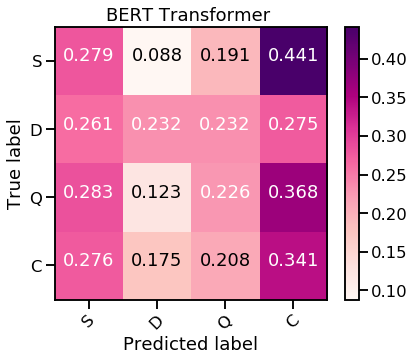

Test_ acc: 0.31733594515181196
Test_ f1 none: [0.109 0.133 0.15  0.469]
Test_ f1 macro: 0.21501233002683212
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 16
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.292 	F-macro_val: 0.217
Epoch 10 	acc_val: 0.375 	F-macro_val: 0.273
Epoch 20 	acc_val: 0.441 	F-macro_val: 0.341
Testing run # 16
SE TUVIERON QUE REPETIR 3 EJEMPLOS


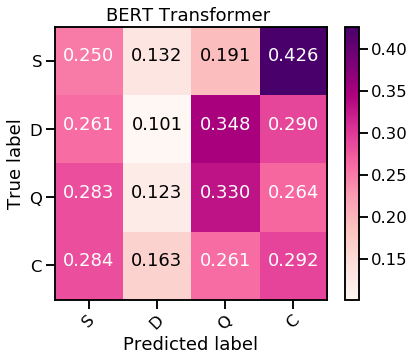

Test_ acc: 0.2801175318315377
Test_ f1 none: [0.096 0.062 0.184 0.42 ]
Test_ f1 macro: 0.1903969499348156
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 17
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.236 	F-macro_val: 0.197
Epoch 10 	acc_val: 0.378 	F-macro_val: 0.273
Epoch 20 	acc_val: 0.444 	F-macro_val: 0.323
Testing run # 17
SE TUVIERON QUE REPETIR 3 EJEMPLOS


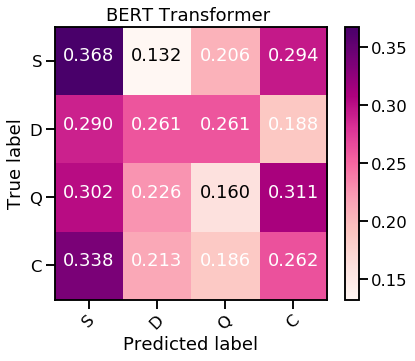

Test_ acc: 0.25857002938295787
Test_ f1 none: [0.123 0.126 0.113 0.389]
Test_ f1 macro: 0.18776736397863475
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 18
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.215 	F-macro_val: 0.183
Epoch 10 	acc_val: 0.372 	F-macro_val: 0.289
Epoch 20 	acc_val: 0.420 	F-macro_val: 0.312
Testing run # 18
SE TUVIERON QUE REPETIR 3 EJEMPLOS


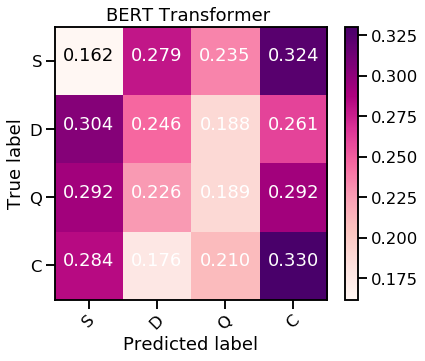

Test_ acc: 0.2987267384916748
Test_ f1 none: [0.062 0.128 0.126 0.465]
Test_ f1 macro: 0.19521087656147773
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 19
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.333 	F-macro_val: 0.229
Epoch 10 	acc_val: 0.358 	F-macro_val: 0.284
Epoch 20 	acc_val: 0.389 	F-macro_val: 0.316
Testing run # 19
SE TUVIERON QUE REPETIR 3 EJEMPLOS


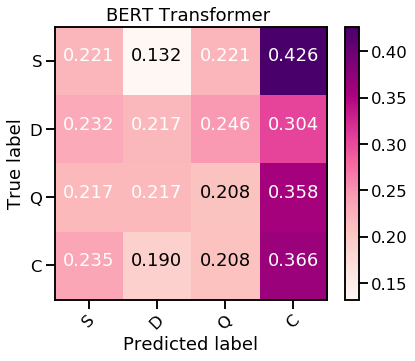

Test_ acc: 0.33006856023506365
Test_ f1 none: [0.098 0.114 0.137 0.495]
Test_ f1 macro: 0.2109661321470771
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 20
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.229 	F-macro_val: 0.197
Epoch 10 	acc_val: 0.278 	F-macro_val: 0.229
Epoch 20 	acc_val: 0.385 	F-macro_val: 0.295
Testing run # 20
SE TUVIERON QUE REPETIR 3 EJEMPLOS


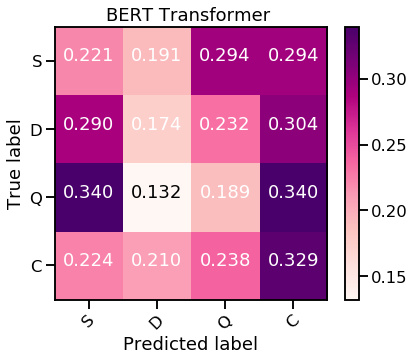

Test_ acc: 0.29676787463271304
Test_ f1 none: [0.096 0.089 0.115 0.461]
Test_ f1 macro: 0.19013184770021685


In [73]:
best_50, all_accs_50, all_fno_50, all_ma_50, all_cm_50 = train_transformer(0.5, 30, path_a, path_m, "RdPu", augmented=True)

In [74]:
print ("best_50", best_50)
print ("all_accs_50", all_accs_50)
print ("all_fno_50", all_fno_50)
print ("all_ma_50", all_ma_50)

best_50 {'F_ma': 0.2378550038087205, 'Run': 9}
all_accs_50 [0.24485798237022527, 0.22135161606268364, 0.2761998041136141, 0.2908912830558276, 0.2840352595494613, 0.2683643486777669, 0.2605288932419197, 0.366307541625857, 0.3770812928501469, 0.22820763956904996, 0.3143976493633692, 0.28305582761998044, 0.24877571008814886, 0.376101860920666, 0.31733594515181196, 0.2801175318315377, 0.25857002938295787, 0.2987267384916748, 0.33006856023506365, 0.29676787463271304]
all_fno_50 [array([0.105, 0.071, 0.155, 0.367]), array([0.118, 0.113, 0.183, 0.308]), array([0.07 , 0.118, 0.163, 0.418]), array([0.062, 0.07 , 0.155, 0.451]), array([0.126, 0.159, 0.088, 0.427]), array([0.094, 0.13 , 0.199, 0.393]), array([0.139, 0.084, 0.108, 0.398]), array([0.156, 0.1  , 0.134, 0.538]), array([0.133, 0.129, 0.141, 0.548]), array([0.117, 0.121, 0.17 , 0.324]), array([0.085, 0.11 , 0.13 , 0.481]), array([0.123, 0.114, 0.142, 0.425]), array([0.078, 0.107, 0.12 , 0.389]), array([0.11 , 0.088, 0.118, 0.557]), arr

Acc: 0.291 -- deviation: 0.044
F-score: 0.198 -- deviation: 0.017
(0.5) SDQC: 0.10491890354644848 0.10825387182905907 0.1414854677921584 0.436128582808618


Confusion counts
[[ 347.  255.  313.  445.]
 [ 345.  304.  355.  376.]
 [ 553.  421.  488.  658.]
 [4079. 3129. 3547. 4805.]]


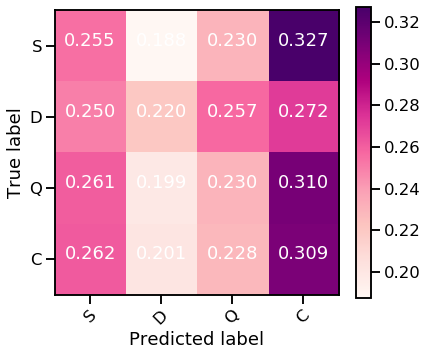

In [75]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_50)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_50)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_50)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_50)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_50)[:,0])
den=np.mean(np.asarray(all_fno_50)[:,1])
que=np.mean(np.asarray(all_fno_50)[:,2])
com=np.mean(np.asarray(all_fno_50)[:,3])

print ("(0.5) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_50:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S", "D", "Q", "C"], "", cmap='RdPu')

## 0.85 -- 10 run

Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.253 	F-macro_val: 0.185
Epoch 10 	acc_val: 0.285 	F-macro_val: 0.211
Epoch 20 	acc_val: 0.372 	F-macro_val: 0.274
Testing run # 1
SE TUVIERON QUE REPETIR 3 EJEMPLOS


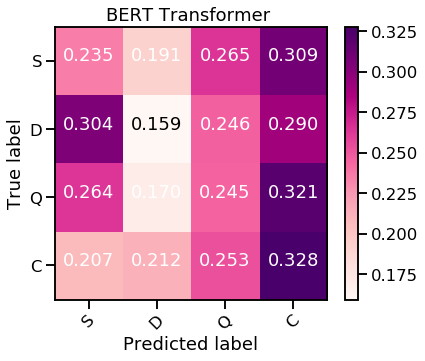

Test_ acc: 0.30166503428011754
Test_ f1 none: [0.109 0.08  0.143 0.46 ]
Test_ f1 macro: 0.19792490846597624


Nuevo best encontrado:

Acc: 0.302 	F1-ma: 0.198
	F1-none:  [0.109 0.08  0.143 0.46 ]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.257 	F-macro_val: 0.212
Epoch 10 	acc_val: 0.389 	F-macro_val: 0.300
Epoch 20 	acc_val: 0.451 	F-macro_val: 0.363
Testing run # 2
SE TUVIERON QUE REPETIR 3 EJEMPLOS


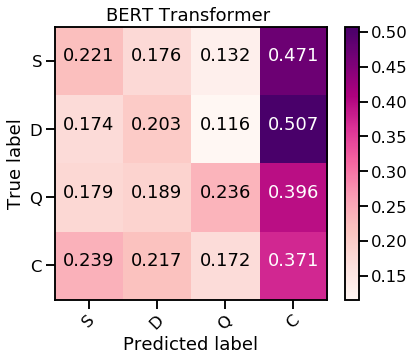

Test_ acc: 0.33594515181194906
Test_ f1 none: [0.1   0.099 0.177 0.491]
Test_ f1 macro: 0.2168482781185594


Nuevo best encontrado:

Acc: 0.336 	F1-ma: 0.217
	F1-none:  [0.1   0.099 0.177 0.491]
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.281 	F-macro_val: 0.181
Epoch 10 	acc_val: 0.312 	F-macro_val: 0.248
Epoch 20 	acc_val: 0.427 	F-macro_val: 0.317
Testing run # 3
SE TUVIERON QUE REPETIR 3 EJEMPLOS


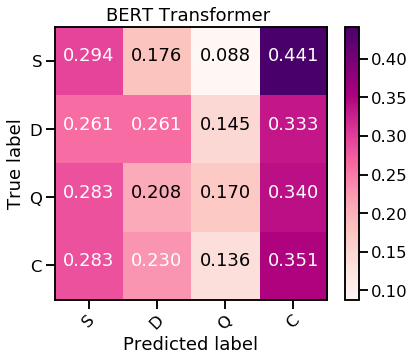

Test_ acc: 0.32223310479921646
Test_ f1 none: [0.112 0.12  0.146 0.479]
Test_ f1 macro: 0.21441209559937113
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.285 	F-macro_val: 0.218
Epoch 10 	acc_val: 0.302 	F-macro_val: 0.228
Epoch 20 	acc_val: 0.448 	F-macro_val: 0.331
Testing run # 4
SE TUVIERON QUE REPETIR 3 EJEMPLOS


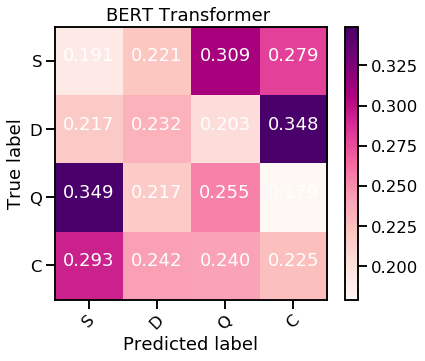

Test_ acc: 0.22624877571008814
Test_ f1 none: [0.072 0.103 0.152 0.345]
Test_ f1 macro: 0.16796407840082392
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.188 	F-macro_val: 0.132
Epoch 10 	acc_val: 0.326 	F-macro_val: 0.229
Epoch 20 	acc_val: 0.330 	F-macro_val: 0.264
Testing run # 5
SE TUVIERON QUE REPETIR 3 EJEMPLOS


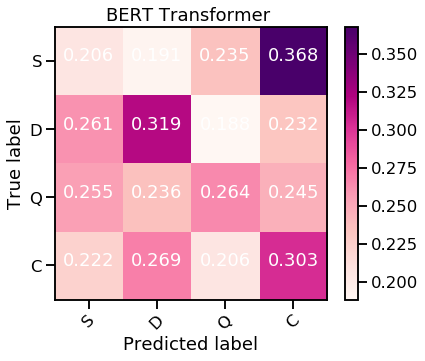

Test_ acc: 0.2938295788442703
Test_ f1 none: [0.093 0.13  0.173 0.437]
Test_ f1 macro: 0.20837955214634699
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 6
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.220
Epoch 10 	acc_val: 0.375 	F-macro_val: 0.288
Epoch 20 	acc_val: 0.375 	F-macro_val: 0.289
Testing run # 6
SE TUVIERON QUE REPETIR 3 EJEMPLOS


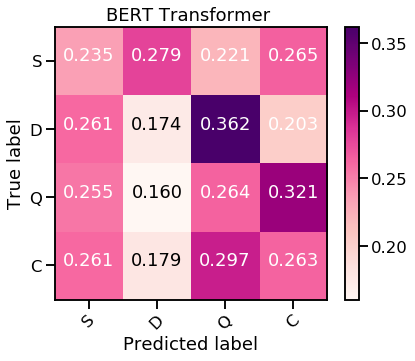

Test_ acc: 0.2556317335945152
Test_ f1 none: [0.096 0.094 0.138 0.391]
Test_ f1 macro: 0.17981389354508737
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 7
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.264 	F-macro_val: 0.195
Epoch 10 	acc_val: 0.378 	F-macro_val: 0.279
Epoch 20 	acc_val: 0.431 	F-macro_val: 0.340
Testing run # 7
SE TUVIERON QUE REPETIR 3 EJEMPLOS


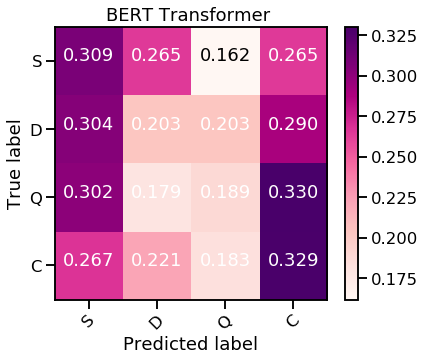

Test_ acc: 0.3046033300685602
Test_ f1 none: [0.12  0.096 0.137 0.463]
Test_ f1 macro: 0.20373011851738665
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 8
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.306 	F-macro_val: 0.218
Epoch 10 	acc_val: 0.399 	F-macro_val: 0.294
Epoch 20 	acc_val: 0.458 	F-macro_val: 0.333
Testing run # 8
SE TUVIERON QUE REPETIR 3 EJEMPLOS


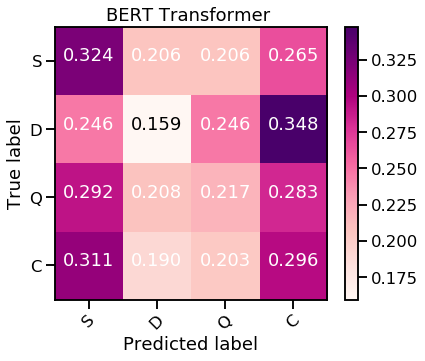

Test_ acc: 0.2801175318315377
Test_ f1 none: [0.116 0.083 0.145 0.426]
Test_ f1 macro: 0.19242570524844604
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 9
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.267 	F-macro_val: 0.219
Epoch 10 	acc_val: 0.295 	F-macro_val: 0.201
Epoch 20 	acc_val: 0.385 	F-macro_val: 0.275
Testing run # 9
SE TUVIERON QUE REPETIR 3 EJEMPLOS


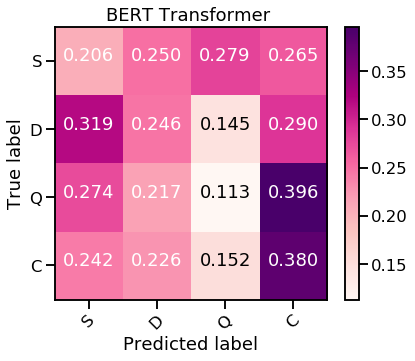

Test_ acc: 0.33202742409402547
Test_ f1 none: [0.087 0.113 0.091 0.513]
Test_ f1 macro: 0.20084362510519194
Pesos de clases: [1. 1. 1. 1.]
Entrenando Run # 10
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.319 	F-macro_val: 0.235
Epoch 10 	acc_val: 0.392 	F-macro_val: 0.285
Epoch 20 	acc_val: 0.424 	F-macro_val: 0.349
Testing run # 10
SE TUVIERON QUE REPETIR 3 EJEMPLOS


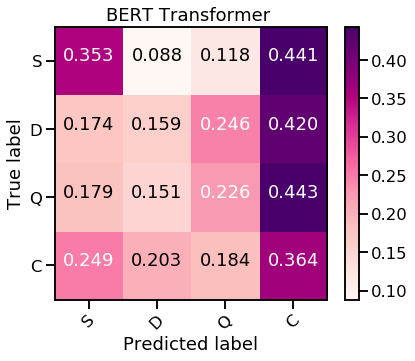

Test_ acc: 0.33496571988246815
Test_ f1 none: [0.151 0.085 0.161 0.485]
Test_ f1 macro: 0.22052826324212688


Nuevo best encontrado:

Acc: 0.335 	F1-ma: 0.221
	F1-none:  [0.151 0.085 0.161 0.485]


In [76]:
### solo 10!! 
best_85, all_accs_85, all_fno_85, all_ma_85, all_cm_85 =train_transformer(0.85, 30, path_a, path_m, "RdPu", xfrom=1, xto=10, augmented=True)

In [77]:
print ("best_85", best_85)
print ("all_accs_85", all_accs_85)
print ("all_fno_85", all_fno_85)
print ("all_ma_85", all_ma_85)

best_85 {'F_ma': 0.22052826324212688, 'Run': 10}
all_accs_85 [0.30166503428011754, 0.33594515181194906, 0.32223310479921646, 0.22624877571008814, 0.2938295788442703, 0.2556317335945152, 0.3046033300685602, 0.2801175318315377, 0.33202742409402547, 0.33496571988246815]
all_fno_85 [array([0.109, 0.08 , 0.143, 0.46 ]), array([0.1  , 0.099, 0.177, 0.491]), array([0.112, 0.12 , 0.146, 0.479]), array([0.072, 0.103, 0.152, 0.345]), array([0.093, 0.13 , 0.173, 0.437]), array([0.096, 0.094, 0.138, 0.391]), array([0.12 , 0.096, 0.137, 0.463]), array([0.116, 0.083, 0.145, 0.426]), array([0.087, 0.113, 0.091, 0.513]), array([0.151, 0.085, 0.161, 0.485])]
all_ma_85 [0.19792490846597624, 0.2168482781185594, 0.21441209559937113, 0.16796407840082392, 0.20837955214634699, 0.17981389354508737, 0.20373011851738665, 0.19242570524844604, 0.20084362510519194, 0.22052826324212688]


Acc: 0.299 -- deviation: 0.034
F-score: 0.200 -- deviation: 0.016
(0.85) SDQC: 0.10573805705176417 0.10015450100560272 0.1463075187429067 0.4489481305554531


Confusion counts
[[ 175.  139.  137.  229.]
 [ 174.  146.  145.  225.]
 [ 279.  205.  231.  345.]
 [2003. 1703. 1576. 2498.]]


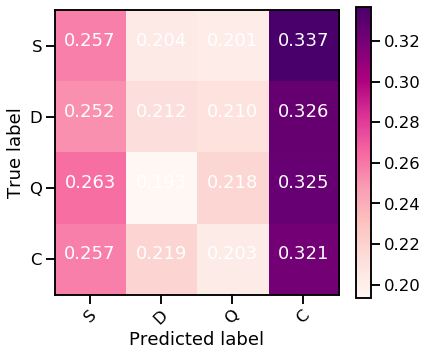

In [78]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(all_accs_85)), "-- deviation: %.3f" % np.std(np.asarray(all_accs_85)))
print ("F-score: %.3f" % np.mean(np.asarray(all_ma_85)), "-- deviation: %.3f" % np.std(np.asarray(all_ma_85)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(all_fno_85)[:,0])
den=np.mean(np.asarray(all_fno_85)[:,1])
que=np.mean(np.asarray(all_fno_85)[:,2])
com=np.mean(np.asarray(all_fno_85)[:,3])

print ("(0.85) SDQC:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in all_cm_85:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["S","D","Q","C"], "", cmap='RdPu')